# Bagian 1: Setup dan Persiapan

In [1]:
!pip install ptflops


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
!pip install torchinfo


In [3]:
!pip install timm

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import cv2
import timm
from timm import create_model  # Untuk EfficientFormerV2
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from torchinfo import summary
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
import json
import torch.optim as optim
import torch.nn.functional as F
import time
from collections import deque
import random
import sys
from ptflops import get_model_complexity_info
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import label_binarize
from glob import glob
from collections import defaultdict
import datetime

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Cek apakah GPU tersedia
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [ ]:
# # Cek apakah GPU tersedia
# DEVICE = torch.device("cpu")
# print("Using device:", DEVICE)

In [3]:
# Konfigurasi parameter utama
DIR_TRAINVAL = r"E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\Pengujian_2\TrainVal\Gabung"  # Train & Validation dataset
DIR_TESTS = {
    # "HockeyFight": r"E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\Pengujian_2\Testing/HockeyFight",
    # "MovieFight": r"E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\Pengujian_2\Testing/MovieFight",
    # "ViolentFlow": r"E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\Pengujian_2\Testing/ViolentFlow",
    # "Automatic": r"E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\Pengujian_2\Testing/Automatic",
    # "Surveilence": r"E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\Pengujian_2\Testing/SurveilFight",
    # "Realife": r"E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\Pengujian_2\Testing/Realife"
    "Primer": r"E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped"
}

SAVE_DIR = r"E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\new_saved_dataset"  # Direktori penyimpanan ekstraksi dataset
CLASSES_LIST = ['NonViolence', 'Violence']
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16
BATCH_SIZE = 8
NUM_CLASSES = len(CLASSES_LIST)

# Transformasi data
transform = transforms.Compose([
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Bagian 2: Preprocessing dan Dataset

In [4]:
# Fungsi untuk ekstraksi frame dari video
def extract_frames(video_path, sequence_length, image_height, image_width):
    """
    Mengambil sejumlah frame dari video dan melakukan preprocessing.

    Args:
        video_path (str): Path ke file video.
        sequence_length (int): Jumlah frame yang akan diambil.
        image_height (int): Tinggi frame setelah resize.
        image_width (int): Lebar frame setelah resize.

    Returns:
        np.ndarray: Array frame yang telah diproses.
    """
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(video_frames_count // sequence_length, 1)

    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (image_width, image_height))
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)

    if len(frames_list) < sequence_length:
        frames_list.extend(frames_list[-1:] * (sequence_length - len(frames_list)))

    video_reader.release()
    return np.array(frames_list, dtype=np.float32)

In [5]:
# ✅ 1. Fungsi set seed agar training reproducible
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ✅ Panggil di awal skrip agar semua bagian training konsisten
set_seed(42)

# ✅ 2. Fungsi untuk split dataset secara konsisten dan tampilkan jumlah

def split_dataset(dataset, val_ratio=0.1, seed=42, save_path=None, load_path=None):
    set_seed(seed)
    total_size = len(dataset)
    val_size = int(total_size * val_ratio)
    train_size = total_size - val_size

    if load_path and os.path.exists(load_path):
        print(f"📂 Memuat indeks split dari {load_path}")
        idx = np.load(load_path)
    else:
        idx = np.random.permutation(total_size)
        if save_path:
            np.save(save_path, idx)
            print(f"💾 Menyimpan indeks split ke {save_path}")

    train_idx = idx[:train_size]
    val_idx = idx[train_size:]

    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    return train_dataset, val_dataset

In [6]:
# Custom Dataset untuk PyTorch dengan Loading Process
class VideoDataset(Dataset):
    def __init__(self, dataset_dir, classes_list, sequence_length, image_height, image_width, transform=None, save_dir=None, dataset_name=None):
        self.dataset_dir = dataset_dir
        self.classes_list = classes_list
        self.sequence_length = sequence_length
        self.image_height = image_height
        self.image_width = image_width
        self.transform = transform
        self.features = []
        self.labels = []

        # Cek apakah dataset sudah diekstrak sebelumnya
        feature_path = os.path.join(save_dir, f"{dataset_name}_features.npy") if save_dir and dataset_name else None
        label_path = os.path.join(save_dir, f"{dataset_name}_labels.npy") if save_dir and dataset_name else None

        if feature_path and label_path and os.path.exists(feature_path) and os.path.exists(label_path):
            print(f"📂 Memuat dataset dari {feature_path} ...")
            self.features = np.load(feature_path, allow_pickle=True)
            self.labels = np.load(label_path, allow_pickle=True)
        else:
            print(f"📂 Mengolah dataset dari: {dataset_dir} ...")
            all_files = []
            for class_name in classes_list:
                class_dir = os.path.join(dataset_dir, class_name)
                all_files += [(class_name, os.path.join(class_dir, file)) for file in os.listdir(class_dir)]

            # **Progress Bar untuk Ekstraksi Dataset**
            for class_name, video_path in tqdm(all_files, desc="📦 Processing Videos", unit="video"):
                class_index = classes_list.index(class_name)
                frames = extract_frames(video_path, sequence_length, image_height, image_width)

                if len(frames) == sequence_length:
                    self.features.append(frames)
                    self.labels.append(class_index)

            # Simpan dataset ke file agar bisa langsung dimuat nanti
            if save_dir and dataset_name:
                os.makedirs(save_dir, exist_ok=True)
                np.save(feature_path, np.array(self.features))
                np.save(label_path, np.array(self.labels))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        frames = np.array(self.features[idx])  # (SEQUENCE_LENGTH, H, W, C)
        label = self.labels[idx]

        frames = torch.tensor(frames, dtype=torch.float32).permute(0, 3, 1, 2)  # (SEQUENCE_LENGTH, C, H, W)

        if self.transform:
            frames = self.transform(frames)


        return frames, torch.tensor(label, dtype=torch.long)

# 🔹 Membuat dataset untuk training & validation
print("\n📂 Membuat dataset training & validation...")
trainval_dataset = VideoDataset(
    dataset_dir=DIR_TRAINVAL,
    classes_list=CLASSES_LIST,
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    transform=transform,
    save_dir=SAVE_DIR,
    dataset_name="trainval"
)

# # Split dataset menjadi Train (80%) dan Validation (10%)
# train_size = int(0.89 * len(trainval_dataset))
# val_size = len(trainval_dataset) - train_size
# train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

train_dataset, val_dataset = split_dataset(
    trainval_dataset,
    val_ratio=0.11,
    seed=42,
    save_path=os.path.join(SAVE_DIR, "split_indices_trainval.npy"),
    load_path=os.path.join(SAVE_DIR, "split_indices_trainval.npy")
)



# DataLoader untuk Train & Validation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"📊 Train Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}")

# 🔹 Membuat dataset uji dari masing-masing direktori
test_loaders = {}
for dataset_name, dir_test in DIR_TESTS.items():
    print(f"📂 Loading test dataset: {dataset_name} ...")
    test_dataset = VideoDataset(
        dataset_dir=dir_test,
        classes_list=CLASSES_LIST,
        sequence_length=SEQUENCE_LENGTH,
        image_height=IMAGE_HEIGHT,
        image_width=IMAGE_WIDTH,
        transform=transform,
        save_dir=SAVE_DIR,
        dataset_name=dataset_name
    )
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loaders[dataset_name] = test_loader

print(f"📊 Dataset uji terbagi ke dalam {len(test_loaders)} kategori dengan total {sum(len(loader.dataset) for loader in test_loaders.values())} sampel.")


📂 Membuat dataset training & validation...
📂 Memuat dataset dari E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\new_saved_dataset\trainval_features.npy ...
📂 Memuat indeks split dari E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\new_saved_dataset\split_indices_trainval.npy
📊 Train Samples: 3278, Validation Samples: 405
📂 Loading test dataset: Primer ...
📂 Mengolah dataset dari: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped ...


📦 Processing Videos:  64%|██████▍   | 144/224 [04:13<02:20,  1.76s/video]


KeyboardInterrupt: 

# Bagian 3: Pembuatan Model

In [ ]:
# model = timm.create_model('efficientformerv2_s0', pretrained=True)
# print(model.default_cfg)


In [7]:
print("\nMembuat model EfficientFormerV2 dengan BiLSTM dan Attention...")

class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.W = nn.Linear(input_dim, input_dim)
        self.b = nn.Parameter(torch.zeros(input_dim))
        self.u = nn.Linear(input_dim, 1)

    def forward(self, x):
        # Step 1: Alignment scores
        u_it = torch.tanh(self.W(x) + self.b)

        # Step 2: Compute attention weights
        att = self.u(u_it)
        att_weights = torch.softmax(att, dim=1)

        # Step 3: Compute context vector
        context = x * att_weights
        output = torch.sum(context, dim=1)

        # Step 4: Add residual connection
        residual = torch.sum(x, dim=1)
        output = output + residual

        return output

class EfficientFormerV2WithBiLSTM(nn.Module):
    def __init__(self, base_model_name, num_classes, hidden_dim=176, lstm_units=32, weight_decay=1e-4, use_attention=True):
        super(EfficientFormerV2WithBiLSTM, self).__init__()
        self.use_attention = use_attention
        self.base_model = create_model(base_model_name, pretrained=True, num_classes=0, in_chans=3)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=lstm_units, batch_first=True, bidirectional=True)
        self.attention = AttentionLayer(lstm_units * 2)
        self.fc_layers = nn.Sequential(
            nn.Linear(lstm_units * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes),

        )
        # Apply L2 regularization (weight decay)
        for module in self.fc_layers:
            if isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight)
                module.weight_decay = weight_decay

    def forward(self, x):
        # print("Input shape to model:", x.shape)  # Debugging
        batch_size, seq_len, c, h, w = x.size()
        # Cek apakah channel pertama adalah 3 (RGB)
        if c != 3:
            raise ValueError(f"Expected 3 channels, but got {c}")
        x = x.view(batch_size * seq_len, c, h, w)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)  # Resize
        features = self.base_model(x)
        features = self.flatten(features)
        features = features.view(batch_size, seq_len, -1)
        features = self.dropout(features)
        lstm_out, _ = self.lstm(features)
        if self.use_attention:
            context = self.attention(lstm_out)  # Attention mechanism
        else:
            context = torch.mean(lstm_out, dim=1)  # Global Average Pooling jika tanpa Attention
        output = self.fc_layers(context)  # Klasifikasi akhir
        return output

use_attention = True  # Ganti ke False untuk pengujian tanpa Attention
model = EfficientFormerV2WithBiLSTM('efficientformerv2_s0', num_classes=NUM_CLASSES, use_attention=use_attention).to(DEVICE)
summary(model, input_size=(BATCH_SIZE, SEQUENCE_LENGTH, 3, IMAGE_HEIGHT, IMAGE_WIDTH), device=DEVICE)


Membuat model EfficientFormerV2 dengan BiLSTM dan Attention...


Layer (type:depth-idx)                                            Output Shape              Param #
EfficientFormerV2WithBiLSTM                                       [8, 2]                    --
├─EfficientFormerV2: 1-1                                          [128, 176]                --
│    └─Stem4: 2-1                                                 [128, 32, 56, 56]         --
│    │    └─ConvNormAct: 3-1                                      [128, 16, 112, 112]       480
│    │    └─ConvNormAct: 3-2                                      [128, 32, 56, 56]         4,704
│    └─Sequential: 2-2                                            [128, 176, 7, 7]          --
│    │    └─EfficientFormerV2Stage: 3-3                           [128, 32, 56, 56]         20,480
│    │    └─EfficientFormerV2Stage: 3-4                           [128, 48, 28, 28]         56,976
│    │    └─EfficientFormerV2Stage: 3-5                           [128, 96, 14, 14]         990,832
│    │    └─EfficientFormerV

# Bagian 4: Training Loop

In [11]:
def evaluate_model(model, test_loader, criterion, device=DEVICE):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds, all_probs = [], [], []  # Tambahkan all_probs untuk menyimpan probabilitas

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Output logits
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Ambil indeks kelas dengan nilai tertinggi
            probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Konversi logits ke probabilitas

            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())  # Simpan probabilitas untuk setiap kelas

    test_loss /= total
    test_acc = correct / total
    return {"loss": test_loss, "accuracy": test_acc}, np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [13]:
# Konfigurasi path
CHECKPOINT_PATH = r"/content/drive/MyDrive/6Dataset_NEW_ERA/EFF_BLSTM_ATT/Output_Pelatihan/EFF2_BLSTM_ATT_StageAll_6dataset_model.pth"
HISTORY_PATH = r"/content/drive/MyDrive/6Dataset_NEW_ERA/EFF_BLSTM_ATT/Output_Pelatihan/EFF2_BLSTM_ATT_StageAll_6dataset_training_history.json"
EVALUATION_PATH =r"/content/drive/MyDrive/6Dataset_NEW_ERA/EFF_BLSTM_ATT/Output_Pelatihan/EFF2_BLSTM_ATT_StageAll_6dataset_evaluation.json"

def save_evaluation_results(history, evaluation, total_training_time, evaluation_path=EVALUATION_PATH):
    evaluation_data = {
        "best_epoch": history.get('best_epoch', 1),
        "best_val_accuracy": history.get('best_val_accuracy', 0.0),
        "train_accuracy": history.get('accuracy', [])[-1] if history.get('accuracy') else 0.0,
        "train_loss": history.get('loss', [])[-1] if history.get('loss') else 0.0,
        "test_accuracy": evaluation.get('accuracy', 0.0),
        "test_loss": evaluation.get('loss', 0.0),
        "total_training_time": total_training_time  # Menambahkan waktu pelatihan total ke dalam evaluasi
    }

    # Menyimpan data evaluasi ke file JSON
    with open(evaluation_path, 'w') as f:
        json.dump(evaluation_data, f, indent=4)
    print(f"✅ Evaluasi disimpan ke {evaluation_path}")


In [14]:
# Fungsi untuk memuat hasil evaluasi
def load_evaluation_results(filename):
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return json.load(f)
    else:
        print("⚠️  Evaluation results file not found.")
        return None

In [15]:
# Fungsi untuk mendapatkan epoch terbaik berdasarkan val_accuracy
def get_best_epoch(history):
    best_epoch = np.argmax(history["val_accuracy"]) + 1
    best_val_acc = np.max(history["val_accuracy"])
    return best_epoch, best_val_acc

In [16]:
# Fungsi untuk menyimpan checkpoint model

def save_checkpoint(model, optimizer, scheduler, epoch, history, checkpoint_path, total_training_time=0.0):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'history': history,
        'total_training_time': total_training_time  # 🕒 simpan waktu
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"💾 Checkpoint tersimpan di {checkpoint_path} (Epoch {epoch})")

In [17]:
# Fungsi untuk memuat checkpoint model

def load_checkpoint(filepath=CHECKPOINT_PATH):
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath, map_location=torch.device(DEVICE))
        epoch = checkpoint.get('epoch', 0)
        history = checkpoint.get('history', {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []})
        optimizer_state = checkpoint.get('optimizer_state_dict', None)
        scheduler_state = checkpoint.get('scheduler_state_dict', None)
        model_state = checkpoint.get('model_state_dict', None)
        total_training_time = checkpoint.get('total_training_time', 0.0)

        best_epoch = np.argmax(history["val_accuracy"]) + 1 if history["val_accuracy"] else 0
        best_val_acc = max(history["val_accuracy"], default=float("-inf"))
        avg_time_per_epoch = total_training_time / epoch if epoch > 0 else 0.0

        print(f"\n📂 Checkpoint ditemukan: {filepath}")
        print(f"🔄 Model sudah dilatih hingga epoch {epoch}")
        print(f"📌 Best Epoch: {best_epoch}")
        print(f"📈 Best Validation Accuracy: {best_val_acc:.4f}")
        print(f"🏋️‍ Accuracy on Training Set at Best Epoch: {history['accuracy'][best_epoch - 1]}")
        print(f"📉 Loss on Training Set at Best Epoch: {history['loss'][best_epoch - 1]}")
        print(f"🕒 Lama latih hingga epoch {epoch}: {total_training_time:.2f} detik ({total_training_time/60:.2f} menit)")
        print(f"⏱️ Rata-rata waktu per epoch: {avg_time_per_epoch:.2f} detik")

        return checkpoint, epoch + 1, history, optimizer_state, scheduler_state, model_state, total_training_time

    print(f"⚠️ Tidak ditemukan checkpoint di {filepath}")
    return None, 1, {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}, None, None, None, 0.0


# Fungsi untuk memuat history training
def load_training_history(filepath=HISTORY_PATH):
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            return json.load(f)
    return {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}
# Fungsi untuk menyimpan history training
def save_training_history(history, filepath=HISTORY_PATH):
    with open(filepath, 'w') as f:
        json.dump(history, f, indent=4)
    print(f"✅ History training disimpan ke {filepath}")


# Skenario pelatihan

In [18]:
# Skenario 1: Fine-tuning hanya pada Stage-3 (Stage paling akhir pada EfficientFormer)
def setup_optimizer_stage3_only(model, lr_pretrained=1e-5, lr_custom=1e-3):
    for param in model.base_model.parameters():
        param.requires_grad = False
    for param in model.base_model.stages[3].parameters():
        param.requires_grad = True
    for param in model.lstm.parameters():
        param.requires_grad = True
    for param in model.fc_layers.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam([
        {'params': model.base_model.stages[3].parameters(), 'lr': lr_pretrained},
        {'params': model.lstm.parameters(), 'lr': lr_custom},
        {'params': model.fc_layers.parameters(), 'lr': lr_custom}
    ])
    return optimizer

# Penjelasan:
# Kita hanya fine-tune Stage-3 karena bagian ini mempelajari fitur high-level.
# Stage 0-2 dibekukan karena sudah belajar fitur low-level yang cukup general dari ImageNet.


# Skenario 2: Fine-tuning Stage-2 dan Stage-3

def setup_optimizer_stage2_3(model, lr_pretrained=1e-5, lr_custom=1e-3):
    for param in model.base_model.parameters():
        param.requires_grad = False
    for stage_idx in [2, 3]:
        for param in model.base_model.stages[stage_idx].parameters():
            param.requires_grad = True
    for param in model.lstm.parameters():
        param.requires_grad = True
    for param in model.fc_layers.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam([
        {'params': model.base_model.stages[2].parameters(), 'lr': lr_pretrained},
        {'params': model.base_model.stages[3].parameters(), 'lr': lr_pretrained},
        {'params': model.lstm.parameters(), 'lr': lr_custom},
        {'params': model.fc_layers.parameters(), 'lr': lr_custom}
    ])
    return optimizer

# Penjelasan:
# Kita tambahkan Stage-2 untuk dilatih karena semakin ke atas fitur makin abstrak.
# Hal ini dilakukan untuk mengeksplorasi apakah tambahan fine-tuning di Stage-2 membantu kinerja klasifikasi.


# Skenario 3: Full Fine-tuning (All stages EfficientFormer dilatih ulang)

def setup_optimizer_all_stages(model, lr_all=1e-5, lr_custom=1e-3):
    for param in model.base_model.parameters():
        param.requires_grad = True
    for param in model.lstm.parameters():
        param.requires_grad = True
    for param in model.fc_layers.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam([
        {'params': model.base_model.parameters(), 'lr': lr_all},
        {'params': model.lstm.parameters(), 'lr': lr_custom},
        {'params': model.fc_layers.parameters(), 'lr': lr_custom}
    ])
    return optimizer

In [27]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                checkpoint, start_epoch, history, optimizer_state,
                scheduler_state, model_state, total_training_time,
                num_epochs=50, patience=15, device=DEVICE):

    if checkpoint:
        model.load_state_dict(model_state)
        model.to(DEVICE)
        print(f"✅ Model '{CHECKPOINT_PATH}' berhasil dimuat.")
        optimizer.load_state_dict(optimizer_state)
        print(f"🔄 Melanjutkan training dari epoch {start_epoch}")

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.6, patience=3, min_lr=5e-5
    )

    best_val_acc = max(history["val_accuracy"], default=float("-inf"))
    early_stop_counter = 0

    print(f"📌 Training akan dilanjutkan dari epoch {start_epoch}/{num_epochs}")

    for epoch in range(start_epoch, num_epochs + 1):
        start_time = time.time()
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validasi
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        history["loss"].append(train_loss)
        history["accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        epoch_time = time.time() - start_time
        total_training_time += epoch_time

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            history['best_epoch'] = epoch
            history['best_val_accuracy'] = val_acc
            save_checkpoint(model, optimizer, scheduler, epoch, history, CHECKPOINT_PATH, total_training_time)
            print(f"✅ Epoch {epoch}: val_accuracy meningkat ke {val_acc:.5f}")
            evaluation, _, _, _ = evaluate_model(model, val_loader, criterion, device=device)
            save_evaluation_results(history, evaluation, total_training_time)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Epoch {epoch}: val_accuracy tidak meningkat ({early_stop_counter}/{patience})")

        print(f"⏱️ Epoch Time: {epoch_time:.2f} detik")
        print(f"📉 Loss: {train_loss:.4f} - Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f} - LR: {scheduler.get_last_lr()[0]:.6f}")
        # lr_groups = scheduler.get_last_lr()
        # lr_str = ' | '.join([f"Group {i} LR: {lr:.6f}" for i, lr in enumerate(lr_groups)])
        # print(f"📉 Loss: {train_loss:.4f} - Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
        # print(f"📊 Learning Rates → {lr_str}")

        scheduler.step(val_acc)

        if early_stop_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

    print("✅ Training selesai.")
    print(f"🕒 Total waktu pelatihan: {total_training_time:.2f} detik ({total_training_time / 60:.2f} menit)")
    print(f"⏱️ Rata-rata waktu per epoch: {total_training_time / (epoch if epoch > 0 else 1):.2f} detik")

    history['total_training_time'] = total_training_time
    save_training_history(history)

    return history


# Cek apakah model sudah ada
train_model_flag = False
checkpoint, start_epoch, history, optimizer_state, scheduler_state, model_state, total_training_time = load_checkpoint()
if os.path.exists(CHECKPOINT_PATH):
    print(f"📂 Checkpoint '{CHECKPOINT_PATH}' sudah ada.")
    decision = input("📌 Pilih opsi: [L]oad, [O]verwrite, atau [N]ew model? ").strip().lower()


    if decision == "l":
        model = EfficientFormerV2WithBiLSTM('efficientformerv2_s0', num_classes=NUM_CLASSES, use_attention=True)
        checkpoint, start_epoch, history, optimizer_state, scheduler_state, model_state, total_training_time = load_checkpoint()
        if checkpoint:
            model.load_state_dict(model_state)
            model.to(DEVICE)
            print(f"✅ Model '{CHECKPOINT_PATH}' berhasil dimuat.")
            train_model_flag = True
        else:
            print("❌ Checkpoint tidak ditemukan.")
    elif decision in ["o", "n"]:
        print(f"⚠️ Checkpoint '{CHECKPOINT_PATH}' akan ditimpa.")
        train_model_flag = True
else:
    print("❌ Model tidak ditemukan, membuat model baru.")
    train_model_flag = True


# Pelatihan model sesuai skenario
if train_model_flag:
    model = EfficientFormerV2WithBiLSTM('efficientformerv2_s0', num_classes=NUM_CLASSES, use_attention=True).to(DEVICE)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
     # Contoh untuk Skenario Stage-3 Only
    optimizer = setup_optimizer_all_stages(model)
    # optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.6, patience=3, min_lr=5e-5)

    history = train_model(
    model, train_loader, val_loader, criterion, optimizer,
    checkpoint, start_epoch, history, optimizer_state, scheduler_state,
    model_state, total_training_time,
    num_epochs=50, patience=15, device=DEVICE
)





📂 Checkpoint ditemukan: /content/drive/MyDrive/6Dataset_NEW_ERA/EFF_BLSTM_ATT/Output_Pelatihan/EFF2_BLSTM_ATT_StageAll_6dataset_model.pth
🔄 Model sudah dilatih hingga epoch 47
📌 Best Epoch: 47
📈 Best Validation Accuracy: 0.9457
🏋️‍ Accuracy on Training Set at Best Epoch: 0.9758999389871873
📉 Loss on Training Set at Best Epoch: 0.253726063613269
🕒 Lama latih hingga epoch 47: 15041.05 detik (250.68 menit)
⏱️ Rata-rata waktu per epoch: 320.02 detik
📂 Checkpoint '/content/drive/MyDrive/6Dataset_NEW_ERA/EFF_BLSTM_ATT/Output_Pelatihan/EFF2_BLSTM_ATT_StageAll_6dataset_model.pth' sudah ada.
📌 Pilih opsi: [L]oad, [O]verwrite, atau [N]ew model? l

📂 Checkpoint ditemukan: /content/drive/MyDrive/6Dataset_NEW_ERA/EFF_BLSTM_ATT/Output_Pelatihan/EFF2_BLSTM_ATT_StageAll_6dataset_model.pth
🔄 Model sudah dilatih hingga epoch 47
📌 Best Epoch: 47
📈 Best Validation Accuracy: 0.9457
🏋️‍ Accuracy on Training Set at Best Epoch: 0.9758999389871873
📉 Loss on Training Set at Best Epoch: 0.253726063613269
🕒 Lama

Epoch 48: val_accuracy tidak meningkat (1/15)
⏱️ Epoch Time: 316.58 detik
📉 Loss: 0.2527 - Acc: 0.9774 - Val Loss: 0.3201 - Val Acc: 0.9383 - LR: 0.000010


Epoch 49: val_accuracy tidak meningkat (2/15)
⏱️ Epoch Time: 317.82 detik
📉 Loss: 0.2544 - Acc: 0.9762 - Val Loss: 0.3125 - Val Acc: 0.9358 - LR: 0.000010


Epoch 50: val_accuracy tidak meningkat (3/15)
⏱️ Epoch Time: 318.02 detik
📉 Loss: 0.2618 - Acc: 0.9701 - Val Loss: 0.3151 - Val Acc: 0.9383 - LR: 0.000010
✅ Training selesai.
🕒 Total waktu pelatihan: 15993.47 detik (266.56 menit)
⏱️ Rata-rata waktu per epoch: 319.87 detik
✅ History training disimpan ke /content/drive/MyDrive/6Dataset_NEW_ERA/EFF_BLSTM_ATT/Output_Pelatihan/EFF2_BLSTM_ATT_StageAll_6dataset_training_history.json


# Bagian 5: Evaluasi Model

In [28]:
# Load and display evaluation results
evaluation_results = load_evaluation_results(EVALUATION_PATH)
if evaluation_results:
    print("\n=== Evaluasi Model ===")
    print(f"📌 Best Epoch: {evaluation_results['best_epoch']}")
    print(f"📈 Best Validation Accuracy: {evaluation_results['best_val_accuracy']:.4f}")
    print(f"🏋️‍♂️ Accuracy on Training Set at Best Epoch: {evaluation_results['train_accuracy']:.4f}")
    print(f"📉 Loss on Training Set at Best Epoch: {evaluation_results['train_loss']:.4f}")
    print(f"🧪 Accuracy on Test Set: {evaluation_results['test_accuracy']:.4f}")
    print(f"📉 Loss on Test Set: {evaluation_results['test_loss']:.4f}")
else:
    print("⚠️  Evaluation results file not found. Training might not have saved it.")



=== Evaluasi Model ===
📌 Best Epoch: 47
📈 Best Validation Accuracy: 0.9457
🏋️‍♂️ Accuracy on Training Set at Best Epoch: 0.9759
📉 Loss on Training Set at Best Epoch: 0.2537
🧪 Accuracy on Test Set: 0.9457
📉 Loss on Test Set: 0.3166


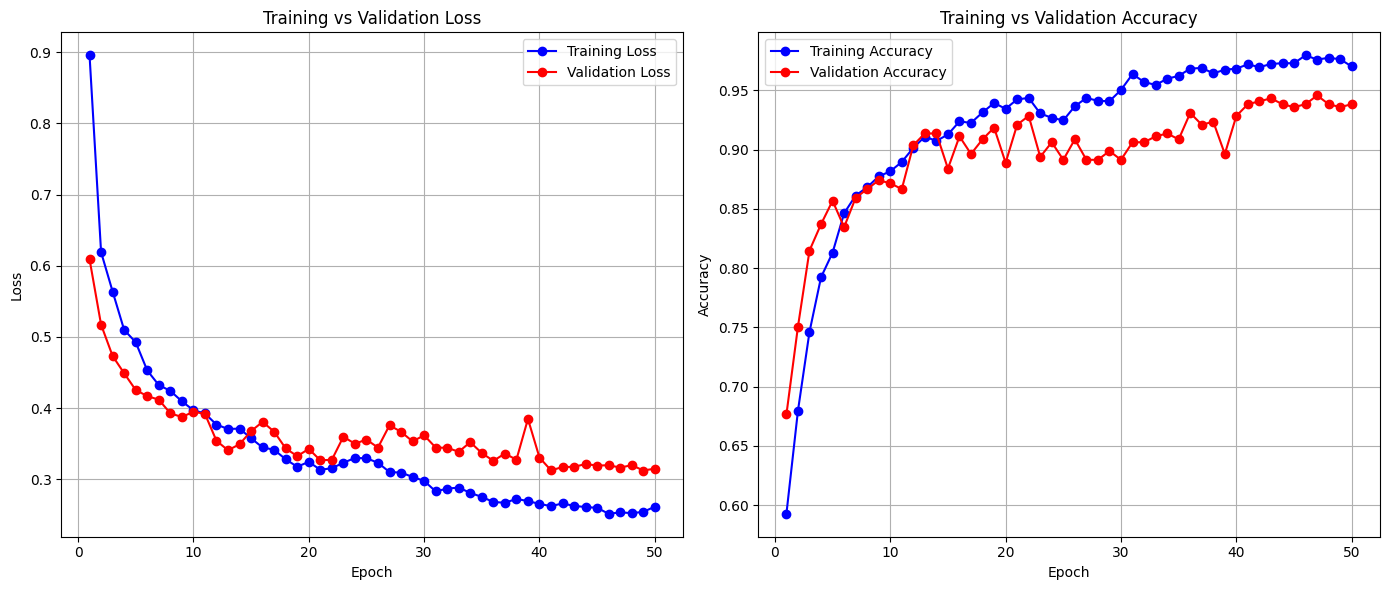

In [29]:
# Memuat data history
history = load_training_history(HISTORY_PATH)

# Cek data history
if not history:
    raise ValueError("History kosong atau tidak ditemukan. Pastikan path benar.")
epochs = range(1, len(history['loss']) + 1)
# Plot grafik Loss per epoch
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


=== Evaluasi pada Dataset: HockeyFight ===
🔍 Accuracy Score on HockeyFight Test Set: 0.9700


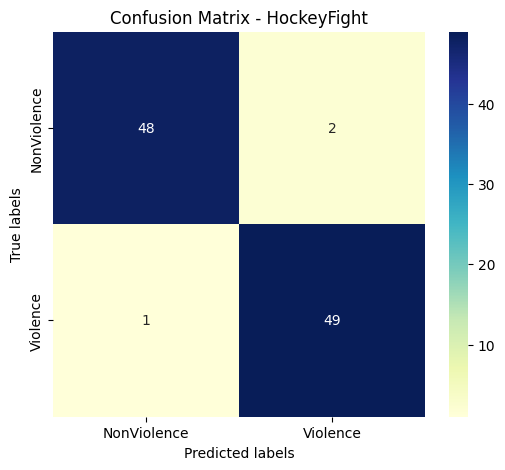

📊 Classification Report (HockeyFight Test Set):
               precision    recall  f1-score   support

 NonViolence       0.98      0.96      0.97        50
    Violence       0.96      0.98      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

📈 AUC Score (macro-averaged) for HockeyFight: 0.9944


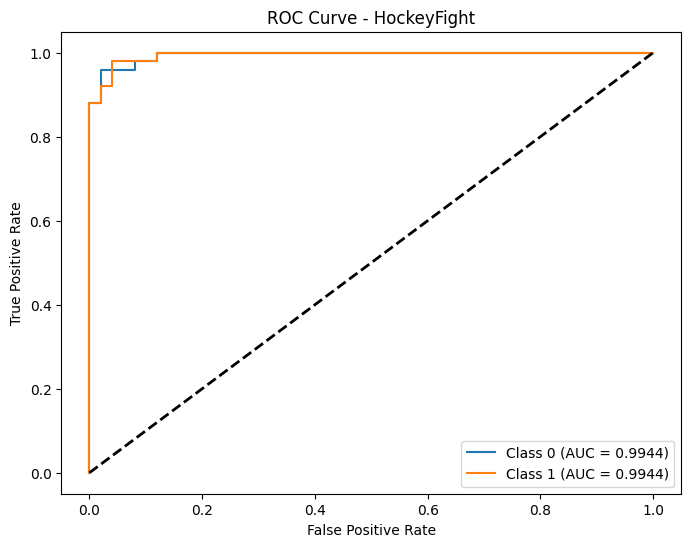


=== Evaluasi pada Dataset: MovieFight ===
🔍 Accuracy Score on MovieFight Test Set: 1.0000


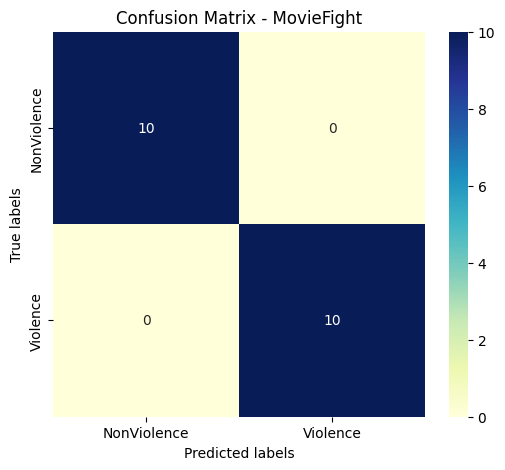

📊 Classification Report (MovieFight Test Set):
               precision    recall  f1-score   support

 NonViolence       1.00      1.00      1.00        10
    Violence       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

📈 AUC Score (macro-averaged) for MovieFight: 1.0000


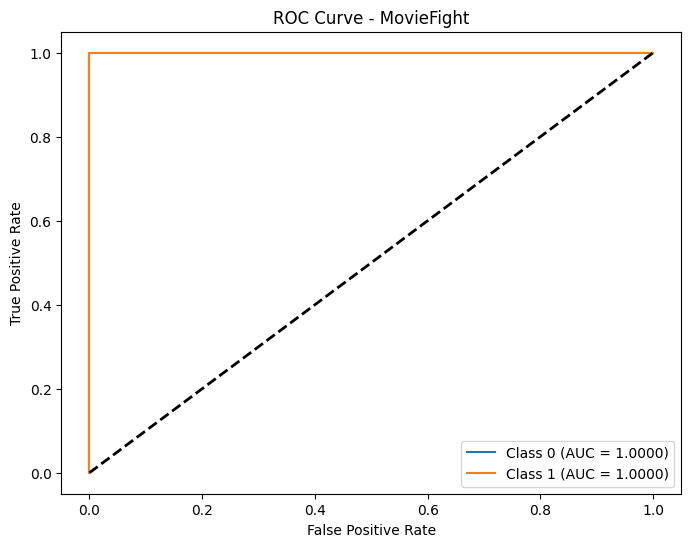


=== Evaluasi pada Dataset: ViolentFlow ===
🔍 Accuracy Score on ViolentFlow Test Set: 0.9615


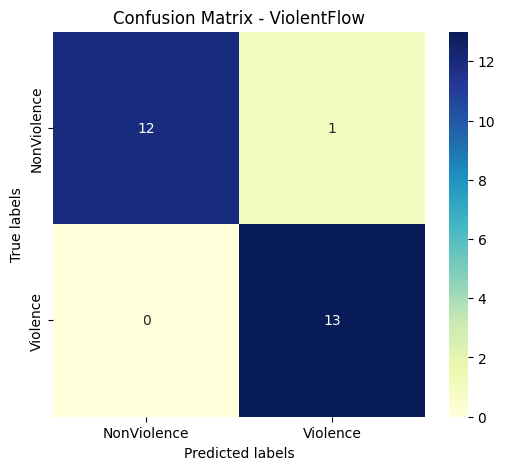

📊 Classification Report (ViolentFlow Test Set):
               precision    recall  f1-score   support

 NonViolence       1.00      0.92      0.96        13
    Violence       0.93      1.00      0.96        13

    accuracy                           0.96        26
   macro avg       0.96      0.96      0.96        26
weighted avg       0.96      0.96      0.96        26

📈 AUC Score (macro-averaged) for ViolentFlow: 0.9941


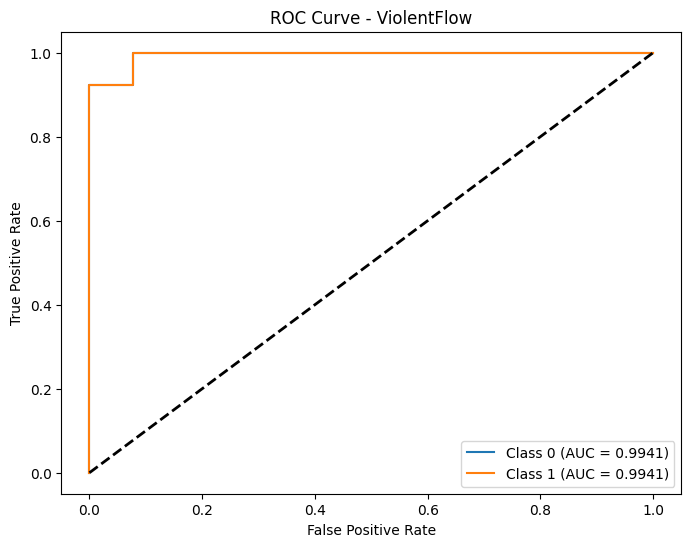


=== Evaluasi pada Dataset: Automatic ===
🔍 Accuracy Score on Automatic Test Set: 0.9714


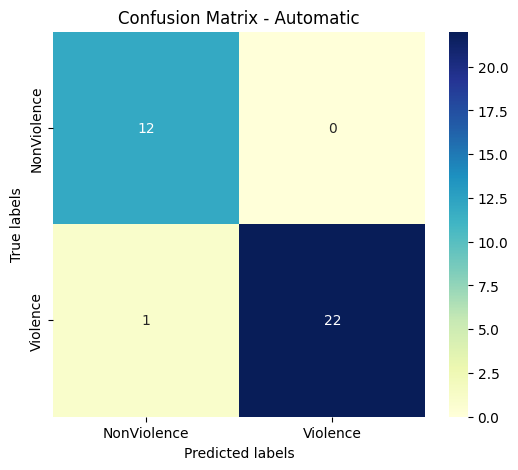

📊 Classification Report (Automatic Test Set):
               precision    recall  f1-score   support

 NonViolence       0.92      1.00      0.96        12
    Violence       1.00      0.96      0.98        23

    accuracy                           0.97        35
   macro avg       0.96      0.98      0.97        35
weighted avg       0.97      0.97      0.97        35

📈 AUC Score (macro-averaged) for Automatic: 0.9964


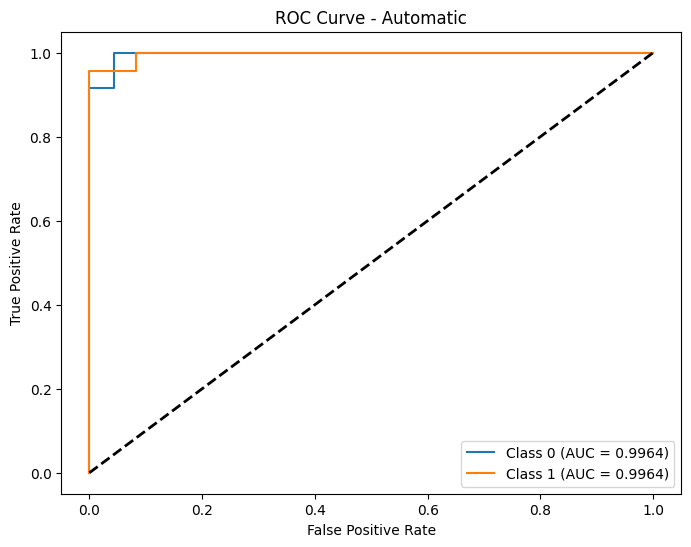


=== Evaluasi pada Dataset: Surveilence ===
🔍 Accuracy Score on Surveilence Test Set: 0.6333


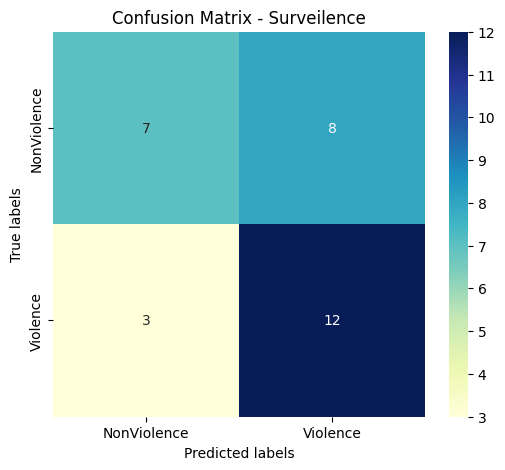

📊 Classification Report (Surveilence Test Set):
               precision    recall  f1-score   support

 NonViolence       0.70      0.47      0.56        15
    Violence       0.60      0.80      0.69        15

    accuracy                           0.63        30
   macro avg       0.65      0.63      0.62        30
weighted avg       0.65      0.63      0.62        30

📈 AUC Score (macro-averaged) for Surveilence: 0.7022


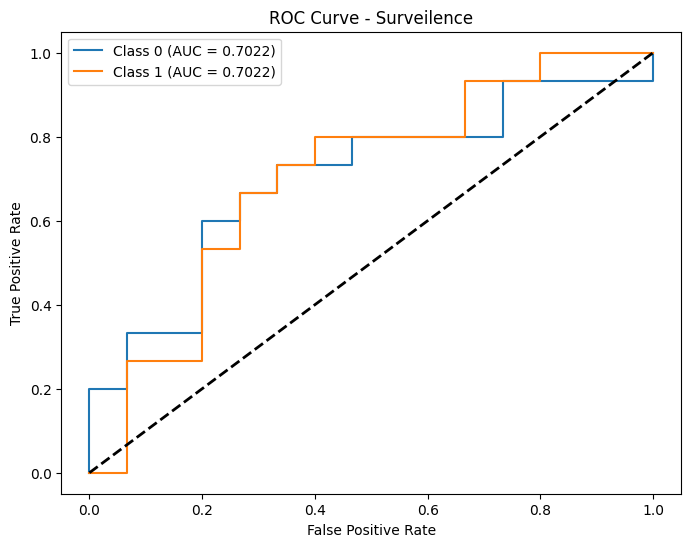


=== Evaluasi pada Dataset: Realife ===
🔍 Accuracy Score on Realife Test Set: 0.9200


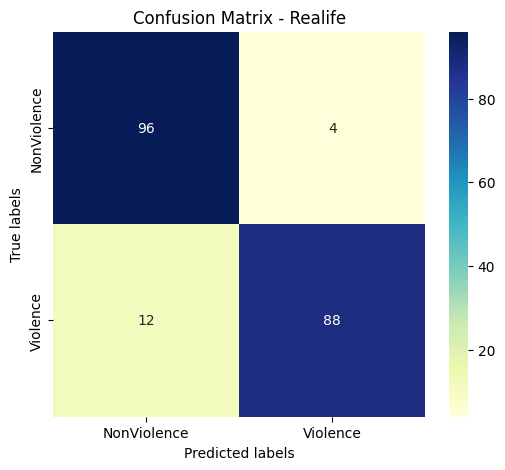

📊 Classification Report (Realife Test Set):
               precision    recall  f1-score   support

 NonViolence       0.89      0.96      0.92       100
    Violence       0.96      0.88      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200

📈 AUC Score (macro-averaged) for Realife: 0.9792


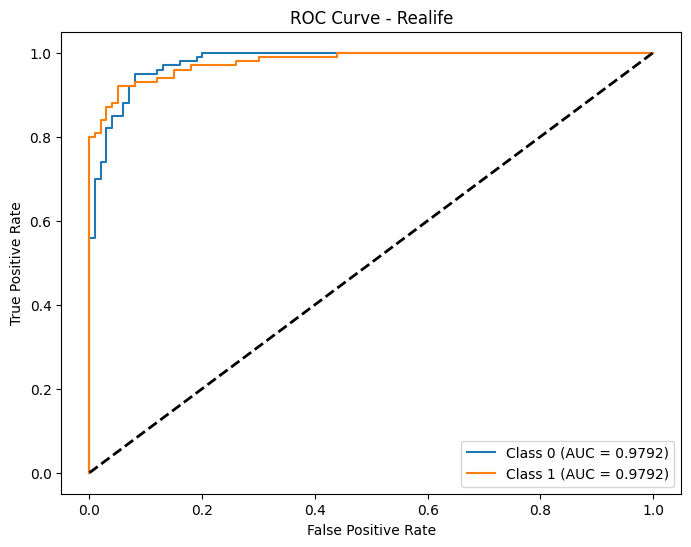


🚀 Evaluating GFLOPs and Latency...
🧮 Model GFLOPs: 6.23 GMac
⚙️ Model Parameters: 3.36 M
⏳ Inference time per sample: 22.014 ms
📦 Memory allocated: 1.001 GB
📦 Max memory allocated: 8.322 GB


In [31]:
# **2️⃣ Evaluasi model pada setiap dataset uji**
for dataset_name, test_loader in test_loaders.items():
    print(f"\n=== Evaluasi pada Dataset: {dataset_name} ===")

    # Evaluasi model
    evaluation, labels_test, labels_pred, probs_pred = evaluate_model(model, test_loader,criterion, device=DEVICE)

    # **Hitung Accuracy**
    AccScore = accuracy_score(labels_test, labels_pred)
    print(f'🔍 Accuracy Score on {dataset_name} Test Set: {AccScore:.4f}')

    # **Plot Confusion Matrix**
    cm = confusion_matrix(labels_test, labels_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu", xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.show()

    # **Tampilkan Classification Report**
    print(f"📊 Classification Report ({dataset_name} Test Set):\n", classification_report(labels_test, labels_pred, target_names=CLASSES_LIST))

    # **Hitung AUC-ROC Score**
    if NUM_CLASSES == 2:  # Binary classification
        auc_score = roc_auc_score(labels_test, probs_pred[:, 1])  # Gunakan probabilitas kelas "Violence"
    else:  # Multi-class classification
        from sklearn.preprocessing import label_binarize
        labels_test_bin = label_binarize(labels_test, classes=np.arange(NUM_CLASSES))
        auc_score = roc_auc_score(labels_test_bin, probs_pred, multi_class='ovr')

    print(f"📈 AUC Score (macro-averaged) for {dataset_name}: {auc_score:.4f}")

    # **Plot AUC-ROC Curve**
    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(8, 6))
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(labels_test == i, probs_pred[:, i])
        roc_auc[i] = roc_auc_score(labels_test == i, probs_pred[:, i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend()
    plt.show()

# **3️⃣ Evaluasi GFLOPs, Latency, dan Penggunaan Memori**
print("\n🚀 Evaluating GFLOPs and Latency...")

# **Evaluasi FLOPs dan jumlah parameter model**
flops, params = get_model_complexity_info(
    model, (SEQUENCE_LENGTH, 3, IMAGE_HEIGHT, IMAGE_WIDTH), as_strings=True, print_per_layer_stat=False
)
print(f"🧮 Model GFLOPs: {flops}")
print(f"⚙️ Model Parameters: {params}")

# **Evaluasi Latency Inferensi**
start_time = time.time()
dummy_input = torch.randn(1, SEQUENCE_LENGTH, 3, IMAGE_HEIGHT, IMAGE_WIDTH).to(DEVICE)
_ = model(dummy_input)
inference_time = (time.time() - start_time) * 1000
print(f"⏳ Inference time per sample: {inference_time:.3f} ms")

# **Evaluasi Penggunaan Memori GPU (Jika tersedia)**
if torch.cuda.is_available():
    print(f"📦 Memory allocated: {torch.cuda.memory_allocated(DEVICE) / 1024**3:.3f} GB")
    print(f"📦 Max memory allocated: {torch.cuda.max_memory_allocated(DEVICE) / 1024**3:.3f} GB")

# Bagian 6: Prediksi pada Video     

In [8]:
# Load model
# model_filename = r'E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\Pengujian_2\Output_Pelatihan_2\Eff2Bilstm_checkpoint.pth'
model_filename = r'E:\KULIAH\TA_SI_GUE\deteksi_kekerasan_ta\checkpoints\Eff2Bilstm_checkpoint.pth'
model = EfficientFormerV2WithBiLSTM('efficientformerv2_s0', num_classes=NUM_CLASSES, use_attention=True)

# Load checkpoint dengan deteksi error
checkpoint = torch.load(model_filename, map_location=DEVICE)
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)  # Jika model berbeda
else:
    model.load_state_dict(checkpoint, strict=False)

# Pindahkan ke device
model.to(DEVICE)
model.eval()
print("✅ Model berhasil dimuat!")


✅ Model berhasil dimuat!


In [9]:
# Fungsi untuk mendapatkan informasi video
def get_video_info(video_path):
    video_reader = cv2.VideoCapture(video_path)
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video_reader.get(cv2.CAP_PROP_FPS)
    duration = total_frames / fps if fps > 0 else 0
    frame_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_reader.release()

    print(f"--- Info Video: {video_path} ---")
    print(f"Total Frame: {total_frames}")
    print(f"Durasi Video: {duration:.2f} detik")
    print(f"Resolusi Frame: {frame_width}x{frame_height}")
    print(f"FPS Video: {fps:.1f}")
    print(f"Jumlah Frame Ekstraksi: {SEQUENCE_LENGTH}\n")

    return total_frames, fps, duration, frame_width, frame_height

# Fungsi untuk memproses video dan membuat prediksi
def predict_frames(video_file_path, output_file_path, sequence_length):

    # Ambil informasi video
    total_frames, fps, duration, frame_width, frame_height = get_video_info(video_file_path)

    video_reader = cv2.VideoCapture(video_file_path)
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    frames_queue = deque(maxlen=sequence_length)
    predicted_class_name = ''
    inference_times = []

    # Progress bar untuk monitoring proses
    progress_bar = tqdm(total=total_frames, desc="Processing Video", unit="frame", leave=True, dynamic_ncols=True)


    while video_reader.isOpened():
        ret, frame = video_reader.read()
        if not ret:
            break

        start_time = time.time()  # Mulai waktu inferensi

        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame / 255.0
        frames_queue.append(normalized_frame)

        if len(frames_queue) == sequence_length:
            input_frames = np.array(frames_queue, dtype=np.float32)
            input_frames = np.transpose(input_frames, (0, 3, 1, 2))  # Ubah format ke (SEQUENCE_LENGTH, 3, H, W)
            input_tensor = torch.tensor(input_frames, dtype=torch.float32).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                predicted_labels_probabilities = model(input_tensor)
                predicted_label = torch.argmax(predicted_labels_probabilities, dim=1).cpu().numpy()[0]
                predicted_class_name = CLASSES_LIST[predicted_label]

        end_time = time.time()  # Akhiri waktu inferensi
        inference_times.append(end_time - start_time)

        # Overlay informasi pada frame
        color = (0, 0, 255) if predicted_class_name == "Violence" else (0, 255, 0)
        cv2.putText(frame, f"{predicted_class_name}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        cv2.putText(frame, f"Frame: {progress_bar.n}/{total_frames}", (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        # cv2.putText(frame, f"FPS: {fps:.1f}", (20, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        video_writer.write(frame)
        progress_bar.update(1)

    video_reader.release()
    video_writer.release()
    progress_bar.close()

    print(f"Video telah diproses dan disimpan di: {output_file_path}")
    avg_inference_time = np.mean(inference_times)
    print(f"\nRata-rata waktu inferensi per video: {avg_inference_time:.4f} detik")

# Fungsi untuk menampilkan frame hasil prediksi
def show_pred_frames(pred_video_path):
    plt.figure(figsize=(20, 15))
    video_reader = cv2.VideoCapture(pred_video_path)
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    num_frames_to_sample = min(12, frames_count - SEQUENCE_LENGTH)
    if num_frames_to_sample <= 0:
        print("Jumlah frame dalam video terlalu sedikit untuk diambil sampel.")
        return

    random_range = sorted(random.sample(range(SEQUENCE_LENGTH, frames_count), num_frames_to_sample))

    for counter, random_index in enumerate(random_range, 1):
        plt.subplot(5, 4, counter)
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
        ok, frame = video_reader.read()
        if not ok:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.tight_layout()

    video_reader.release()


In [12]:
# Path video input dan output
test_videos_directory = r'E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos'
os.makedirs(test_videos_directory, exist_ok=True)
output_video_file_path = f'{test_videos_directory}/Output-Test-Video-1.mp4'
# # input_video_file_path = r'E:\KULIAH\Riset TA\proyek_ta\dataset\Violence\13 (2).mp4'
# input_video_file_path = r'E:\KULIAH\TA_SI_GUE\Tugas_akhir\Automatic\Violence\80.mp4'
# # Lakukan prediksi pada video
# predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Tampilkan beberapa frame hasil prediksi
show_pred_frames(output_video_file_path)

Jumlah frame dalam video terlalu sedikit untuk diambil sampel.


<Figure size 2000x1500 with 0 Axes>

In [26]:
# Ambil sample acak dari masing-masing dataset dan kelas

# def get_random_samples_from_test_dirs(dir_tests, num_samples_per_dataset=100):
#     samples = []
#     for dataset_name, dataset_path in dir_tests.items():
#         all_videos = []
#         for label in CLASSES_LIST:
#             class_path = os.path.join(dataset_path, label)
#             videos = glob(os.path.join(class_path, '*.mp4')) + glob(os.path.join(class_path, '*.avi'))
#             videos = [(video, dataset_name, label) for video in videos]
#             all_videos.extend(videos)
# 
#         # Ambil sample acak tanpa menggandakan kelas terlalu banyak
#         random.shuffle(all_videos)
#         selected = []
#         count = {'Violence': 0, 'NonViolence': 0}
#         for v in all_videos:
#             if len(selected) >= num_samples_per_dataset:
#                 break
#             if count[v[2]] < num_samples_per_dataset - 1:
#                 selected.append(v)
#                 count[v[2]] += 1
# 
#         samples.extend(selected)
#     return samples
def get_random_samples_from_test_dirs(dir_tests, num_samples_per_dataset=100):
    """
    Mengambil sampel seimbang per dataset: 50:50 antara 'Violence' dan 'NonViolence'.
    - Menangani num_samples_per_dataset ganjil (sisa 1 dibagi ke kelas yang masih ada stok).
    - Jika stok salah satu kelas kurang, target per-kelas akan diturunkan agar tetap seimbang.
    - Mencetak ringkasan jumlah terpilih per dataset & per kelas.
    """
    assert 'Violence' in CLASSES_LIST and 'NonViolence' in CLASSES_LIST, \
        "CLASSES_LIST harus memuat 'Violence' dan 'NonViolence'."

    classes = ['Violence', 'NonViolence']  # urutan eksplisit agar konsisten
    samples = []

    for dataset_name, dataset_path in dir_tests.items():
        # Kumpulkan semua video per kelas
        class_to_videos = {}
        for label in classes:
            class_path = os.path.join(dataset_path, label)
            vids = glob(os.path.join(class_path, '*.mp4')) + glob(os.path.join(class_path, '*.avi'))
            random.shuffle(vids)
            class_to_videos[label] = vids

        # Target per kelas (bagi rata)
        base_per_class = num_samples_per_dataset // 2
        remainder = num_samples_per_dataset % 2  # 0 jika genap, 1 jika ganjil

        # Jika stok kurang pada salah satu kelas, turunkan target agar tetap balance
        max_equal_per_class = min(len(class_to_videos['Violence']),
                                  len(class_to_videos['NonViolence']))
        per_class_target = min(base_per_class, max_equal_per_class)

        # Bagikan sisa (jika ganjil) ke kelas yang masih punya stok
        extra_alloc = {'Violence': 0, 'NonViolence': 0}
        if remainder == 1:
            # pilih kelas yang stoknya paling banyak tersisa
            remain_v = len(class_to_videos['Violence']) - per_class_target
            remain_nv = len(class_to_videos['NonViolence']) - per_class_target
            if remain_v <= 0 and remain_nv <= 0:
                # tidak ada stok untuk ekstra; abaikan remainder
                pass
            else:
                give_to = 'Violence' if remain_v >= remain_nv else 'NonViolence'
                extra_alloc[give_to] = 1

        # Seleksi akhir per kelas
        selected_counts = {}
        for label in classes:
            need = per_class_target + extra_alloc[label]
            take = min(need, len(class_to_videos[label]))
            picks = [(v, dataset_name, label) for v in class_to_videos[label][:take]]
            samples.extend(picks)
            selected_counts[label] = take

        # Ringkasan untuk dataset ini
        total_sel = sum(selected_counts.values())
        print(f"[Sampling] {dataset_name}: "
              f"Violence={selected_counts['Violence']}, "
              f"NonViolence={selected_counts['NonViolence']} "
              f"(total={total_sel}, target={num_samples_per_dataset})")
        if total_sel < num_samples_per_dataset:
            print(f"  ⚠️ Stok video tidak mencukupi untuk mencapai target {num_samples_per_dataset}. "
                  f"Mengambil {total_sel} video secara seimbang.")

    return samples

# Proses semua video

def run_batch_gradcam_tests(samples, output_base_dir):
    os.makedirs(output_base_dir, exist_ok=True)
    results = []
    for video_path, dataset_name, label in samples:
        video_name = os.path.basename(video_path).split('.')[0]
        output_path = os.path.join(
            output_base_dir,
            f"Hasil_Gradcam_{dataset_name}_{label}_{video_name}.mp4"
        )

        print(f"\n🎞️ Memproses: {video_name} ({dataset_name}/{label})")
        pred_class, is_correct = predict_frames_with_gradcam(video_path, output_path, SEQUENCE_LENGTH, return_result=True)

        results.append({
            'dataset': dataset_name,
            'label': label,
            'predicted': pred_class,
            'is_correct': is_correct,
            'video': video_name,
            'path': video_path
        })
    return results

# Ringkasan statistik dari hasil batch

def summarize_batch_results(results):
    stats = defaultdict(lambda: {'total': 0, 'correct': 0})
    for r in results:
        stats[r['dataset']]['total'] += 1
        if r['is_correct']:
            stats[r['dataset']]['correct'] += 1

    print("\n📊 Ringkasan Evaluasi Batch:")
    for ds, res in stats.items():
        acc = (res['correct'] / res['total']) * 100
        print(f"- {ds}: {res['correct']}/{res['total']} benar ({acc:.2f}% akurasi)")

    total_correct = sum(r['is_correct'] for r in results)
    total = len(results)
    print(f"\n🎯 Total Akurasi Global: {total_correct}/{total} ({(total_correct/total)*100:.2f}%)")

# Implementasi Grad-CAM untuk EfficientFormerV2
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        """Memasang hook untuk menangkap aktivasi dan gradien."""
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)


    def generate_cam(self, input_tensor, class_idx):
            """Menghasilkan heatmap Grad-CAM untuk input tertentu."""
            self.model.train()  # Pastikan model dalam mode training

            for param in self.model.parameters():
                param.requires_grad = False

            for param in self.target_layer.parameters():
                param.requires_grad = True

            self.model.zero_grad()
            output = self.model(input_tensor)
            one_hot = torch.zeros_like(output)
            one_hot[0, class_idx] = 1
            output.backward(gradient=one_hot)

            self.model.eval()  # Kembalikan model ke mode evaluasi

            gradients = self.gradients.cpu().data.numpy()
            activations = self.activations.cpu().data.numpy()

            weights = np.mean(gradients, axis=(2, 3))
            cam = np.zeros(activations.shape[2:], dtype=np.float32)

            for i, w in enumerate(weights[0]):
                cam += w * activations[0, i]

            cam = np.maximum(cam, 0)  # ReLU

            # Perbaikan: Pastikan max(cam) > 0 sebelum normalisasi
            cam_max = np.max(cam)
            if cam_max > 0:
                cam = cam / cam_max
            else:
                cam = np.zeros_like(cam)  # Jika max(cam) == 0, isi dengan nol untuk menghindari NaN

            cam = cv2.resize(cam, (64, 64))
            return cam


# Fungsi untuk menampilkan Grad-CAM di atas frame video
def apply_gradcam_to_frame(frame, input_tensor, predicted_class):
    cam = grad_cam.generate_cam(input_tensor, predicted_class)

    heatmap = cv2.resize(cam, (frame.shape[1], frame.shape[0]))

    # Perbaikan: Pastikan tidak ada NaN sebelum konversi
    heatmap = np.nan_to_num(heatmap, nan=0.0)  # Gantilah NaN dengan 0
    heatmap = np.uint8(255 * heatmap)  # Ubah ke skala 0-255 dengan aman
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    if frame.shape[-1] == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    assert frame.shape == heatmap.shape, f"Size mismatch: frame={frame.shape}, heatmap={heatmap.shape}"

    superimposed = cv2.addWeighted(frame, 0.6, heatmap, 0.4, 0)
    return superimposed

def predict_frames_with_gradcam(video_file_path, output_file_path, sequence_length,return_result=False):
    tqdm._instances.clear()
    sys.stdout.flush()

    # Ambil informasi video
    total_frames, fps, duration, frame_width, frame_height = get_video_info(video_file_path)

    video_reader = cv2.VideoCapture(video_file_path)
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    frames_queue = deque(maxlen=sequence_length)
    predicted_class_name = ''
    inference_times = []

    violence_count = 0
    nonviolence_count = 0

    progress_bar = tqdm(total=total_frames, desc="Processing Video", unit="frame", leave=True, dynamic_ncols=True)

    while video_reader.isOpened():
        ret, frame = video_reader.read()
        if not ret:
            break

        start_time = time.time()

        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame / 255.0
        frames_queue.append(normalized_frame)

        if len(frames_queue) == sequence_length:
            input_frames = np.array(frames_queue, dtype=np.float32)
            input_frames = np.transpose(input_frames, (0, 3, 1, 2))
            input_tensor = torch.tensor(input_frames, dtype=torch.float32).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                predicted_labels_probabilities = model(input_tensor)
                predicted_label = torch.argmax(predicted_labels_probabilities, dim=1).cpu().numpy()[0]
                predicted_class_name = CLASSES_LIST[predicted_label]

            if predicted_class_name == "Violence":
                violence_count += 1
            else:
                nonviolence_count += 1

            gradcam_frame = apply_gradcam_to_frame(frame, input_tensor, predicted_label)

            color = (0, 0, 255) if predicted_class_name == "Violence" else (0, 255, 0)
            cv2.putText(gradcam_frame, f"{predicted_class_name}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            cv2.putText(gradcam_frame, f"Frame: {progress_bar.n}/{total_frames}", (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            video_writer.write(gradcam_frame)

        end_time = time.time()
        inference_times.append(end_time - start_time)
        progress_bar.update(1)

    video_reader.release()
    video_writer.release()
    progress_bar.close()

    # Ringkasan klasifikasi
    total_preds = violence_count + nonviolence_count
    predominant_class = "Violence" if violence_count > nonviolence_count else "NonViolence"
    violence_ratio = (violence_count / total_preds) * 100 if total_preds > 0 else 0

    # Deteksi Ground Truth berdasarkan path folder
    true_label = "Violence" if "Violence" in video_file_path.replace("\\", "/").split("/") else "NonViolence"
    is_correct = (predominant_class == true_label)

    print(f"\n📊 Ringkasan Prediksi Video:")
    print(f"📁 Nama Video: {os.path.basename(video_file_path)}")
    print(f"🔖 Ground Truth (berdasarkan folder): {true_label}")
    print(f"🧮 Total Frame yang Diprediksi: {total_preds}")
    print(f"🔴 Violence: {violence_count} frame ({violence_ratio:.2f}%)")
    print(f"🟢 NonViolence: {nonviolence_count} frame ({100 - violence_ratio:.2f}%)")
    print(f"🏷️ Prediksi Akhir: {predominant_class}")
    print(f"✅ Kesesuaian: {'✔️ Sesuai' if is_correct else '❌ Tidak Sesuai'}")

    print(f"\n⏱️ Rata-rata waktu inferensi per frame: {np.mean(inference_times):.4f} detik")
    print(f"💾 Output video disimpan di: {output_file_path}")

    if return_result:
        return predominant_class, is_correct


# Fungsi untuk menampilkan frame hasil prediksi dengan Grad-CAM
def show_pred_frames_with_gradcam(pred_video_path):
    plt.figure(figsize=(20, 15))
    video_reader = cv2.VideoCapture(pred_video_path)
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    num_frames_to_sample = min(12, frames_count - SEQUENCE_LENGTH)
    if num_frames_to_sample <= 0:
        print("Jumlah frame dalam video terlalu sedikit untuk diambil sampel.")
        return

    random_range = sorted(random.sample(range(SEQUENCE_LENGTH, frames_count), num_frames_to_sample))

    for counter, random_index in enumerate(random_range, 1):
        plt.subplot(5, 4, counter)
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
        ok, frame = video_reader.read()
        if not ok:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.tight_layout()

    video_reader.release()


# Inisialisasi model dan Grad-CAM
model.eval()
# layer target grad-cam
target_layer = model.base_model.stages[3].blocks[-1]
grad_cam = GradCAM(model, target_layer)


In [16]:
samples = get_random_samples_from_test_dirs(DIR_TESTS, num_samples_per_dataset=100)
results = run_batch_gradcam_tests(samples, test_videos_directory)
summarize_batch_results(results)



🎞️ Memproses: non_violence_028 (Primer/NonViolence)
--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_028.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:26<00:00,  1.92frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_028.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 33 frame (94.29%)
🟢 NonViolence: 2 frame (5.71%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5125 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_028.mp4

🎞️ Memproses: non_violence_010 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_010.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:31<00:00,  2.25frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_010.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 43 frame (78.18%)
🟢 NonViolence: 12 frame (21.82%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4399 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_010.mp4

🎞️ Memproses: non_violence_002 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_002.mp4 ---
Total Frame: 59
Durasi Video: 6.10 detik
Resolusi Frame: 1280x720
FPS Video: 9.7
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 59/59 [00:24<00:00,  2.39frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_002.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 44
🔴 Violence: 2 frame (4.55%)
🟢 NonViolence: 42 frame (95.45%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4152 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_002.mp4

🎞️ Memproses: non_violence_039 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_039.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:31<00:00,  2.20frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_039.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 46 frame (83.64%)
🟢 NonViolence: 9 frame (16.36%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4493 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_039.mp4

🎞️ Memproses: non_violence_096 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_096.mp4 ---
Total Frame: 69
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 9.9
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:31<00:00,  2.21frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_096.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 54 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4475 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_096.mp4

🎞️ Memproses: violence_097 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_097.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:38<00:00,  1.78frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_097.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 108 frame (67.50%)
🟢 NonViolence: 52 frame (32.50%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5526 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_097.mp4

🎞️ Memproses: violence_061 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_061.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:35<00:00,  1.96frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_061.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 19 frame (34.55%)
🟢 NonViolence: 36 frame (65.45%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5034 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_061.mp4

🎞️ Memproses: violence_108 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_108.mp4 ---
Total Frame: 85
Durasi Video: 3.40 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 85/85 [00:41<00:00,  2.05frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_108.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 70
🔴 Violence: 55 frame (78.57%)
🟢 NonViolence: 15 frame (21.43%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4811 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_108.mp4

🎞️ Memproses: violence_024 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_024.mp4 ---
Total Frame: 60
Durasi Video: 6.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 60/60 [00:29<00:00,  2.05frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_024.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 45
🔴 Violence: 45 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4852 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_024.mp4

🎞️ Memproses: violence_094 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_094.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [02:00<00:00,  1.45frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_094.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 92 frame (57.50%)
🟢 NonViolence: 68 frame (42.50%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.6837 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_094.mp4

🎞️ Memproses: non_violence_092 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_092.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:31<00:00,  2.25frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_092.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 53 frame (96.36%)
🟢 NonViolence: 2 frame (3.64%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4384 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_092.mp4

🎞️ Memproses: non_violence_087 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_087.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:30<00:00,  2.27frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_087.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 42 frame (76.36%)
🟢 NonViolence: 13 frame (23.64%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4344 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_087.mp4

🎞️ Memproses: violence_025 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_025.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:26<00:00,  2.03frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_025.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 148 frame (92.50%)
🟢 NonViolence: 12 frame (7.50%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4892 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_025.mp4

🎞️ Memproses: non_violence_097 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_097.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:30<00:00,  2.26frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_097.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 32 frame (58.18%)
🟢 NonViolence: 23 frame (41.82%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4370 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_097.mp4

🎞️ Memproses: violence_043 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_043.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:30<00:00,  2.26frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_043.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 19 frame (34.55%)
🟢 NonViolence: 36 frame (65.45%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4366 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_043.mp4

🎞️ Memproses: non_violence_067 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_067.mp4 ---
Total Frame: 174
Durasi Video: 6.96 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 174/174 [01:37<00:00,  1.78frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_067.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 159
🔴 Violence: 95 frame (59.75%)
🟢 NonViolence: 64 frame (40.25%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5477 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_067.mp4

🎞️ Memproses: non_violence_017 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_017.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:19<00:00,  2.56frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_017.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 7 frame (20.00%)
🟢 NonViolence: 28 frame (80.00%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.3854 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_017.mp4

🎞️ Memproses: violence_050 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_050.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:30<00:00,  2.27frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_050.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 28 frame (50.91%)
🟢 NonViolence: 27 frame (49.09%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4344 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_050.mp4

🎞️ Memproses: non_violence_024 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_024.mp4 ---
Total Frame: 69
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 9.9
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:30<00:00,  2.25frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_024.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 22 frame (40.74%)
🟢 NonViolence: 32 frame (59.26%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4391 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_024.mp4

🎞️ Memproses: violence_051 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_051.mp4 ---
Total Frame: 60
Durasi Video: 6.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 60/60 [00:25<00:00,  2.35frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_051.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 45
🔴 Violence: 45 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4203 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_051.mp4

🎞️ Memproses: non_violence_066 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_066.mp4 ---
Total Frame: 174
Durasi Video: 6.96 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 174/174 [01:38<00:00,  1.77frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_066.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 159
🔴 Violence: 92 frame (57.86%)
🟢 NonViolence: 67 frame (42.14%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5530 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_066.mp4

🎞️ Memproses: non_violence_074 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_074.mp4 ---
Total Frame: 69
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 9.9
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:30<00:00,  2.29frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_074.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 38 frame (70.37%)
🟢 NonViolence: 16 frame (29.63%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4313 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_074.mp4

🎞️ Memproses: violence_026 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_026.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:29<00:00,  2.36frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_026.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 53 frame (96.36%)
🟢 NonViolence: 2 frame (3.64%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4205 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_026.mp4

🎞️ Memproses: non_violence_077 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_077.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:30<00:00,  2.27frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_077.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 12 frame (21.82%)
🟢 NonViolence: 43 frame (78.18%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4349 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_077.mp4

🎞️ Memproses: non_violence_014 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_014.mp4 ---
Total Frame: 69
Durasi Video: 7.10 detik
Resolusi Frame: 1920x1080
FPS Video: 9.7
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:30<00:00,  2.28frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_014.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 14 frame (25.93%)
🟢 NonViolence: 40 frame (74.07%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4332 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_014.mp4

🎞️ Memproses: violence_074 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_074.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:30<00:00,  1.94frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_074.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 79 frame (49.38%)
🟢 NonViolence: 81 frame (50.62%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5106 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_074.mp4

🎞️ Memproses: violence_023 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_023.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:29<00:00,  2.35frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_023.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 51 frame (92.73%)
🟢 NonViolence: 4 frame (7.27%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4222 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_023.mp4

🎞️ Memproses: violence_008 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_008.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:19<00:00,  2.58frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_008.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 0 frame (0.00%)
🟢 NonViolence: 35 frame (100.00%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.3838 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_008.mp4

🎞️ Memproses: non_violence_003 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_003.mp4 ---
Total Frame: 49
Durasi Video: 5.10 detik
Resolusi Frame: 1280x720
FPS Video: 9.6
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 49/49 [00:18<00:00,  2.69frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_003.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 34
🔴 Violence: 16 frame (47.06%)
🟢 NonViolence: 18 frame (52.94%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.3682 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_003.mp4

🎞️ Memproses: violence_054 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_054.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:19<00:00,  2.56frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_054.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 34 frame (97.14%)
🟢 NonViolence: 1 frame (2.86%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.3850 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_054.mp4

🎞️ Memproses: non_violence_042 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_042.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:19<00:00,  2.57frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_042.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 30 frame (85.71%)
🟢 NonViolence: 5 frame (14.29%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.3834 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_042.mp4

🎞️ Memproses: non_violence_025 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_025.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:31<00:00,  2.21frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_025.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 20 frame (36.36%)
🟢 NonViolence: 35 frame (63.64%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4470 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_025.mp4

🎞️ Memproses: violence_011 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_011.mp4 ---
Total Frame: 69
Durasi Video: 7.10 detik
Resolusi Frame: 1280x720
FPS Video: 9.7
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:29<00:00,  2.32frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_011.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 36 frame (66.67%)
🟢 NonViolence: 18 frame (33.33%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4269 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_011.mp4

🎞️ Memproses: non_violence_043 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_043.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:19<00:00,  2.51frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_043.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 25 frame (71.43%)
🟢 NonViolence: 10 frame (28.57%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.3922 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_043.mp4

🎞️ Memproses: violence_082 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_082.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:30<00:00,  1.93frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_082.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 96 frame (60.00%)
🟢 NonViolence: 64 frame (40.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5110 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_082.mp4

🎞️ Memproses: violence_022 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_022.mp4 ---
Total Frame: 69
Durasi Video: 6.90 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:29<00:00,  2.37frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_022.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 54 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4191 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_022.mp4

🎞️ Memproses: non_violence_006 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_006.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:29<00:00,  2.35frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_006.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 11 frame (20.00%)
🟢 NonViolence: 44 frame (80.00%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4222 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_006.mp4

🎞️ Memproses: violence_062 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_062.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:31<00:00,  2.22frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_062.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 54 frame (98.18%)
🟢 NonViolence: 1 frame (1.82%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4418 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_062.mp4

🎞️ Memproses: non_violence_048 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_048.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:37<00:00,  1.79frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_048.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 123 frame (76.88%)
🟢 NonViolence: 37 frame (23.12%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5441 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_048.mp4

🎞️ Memproses: violence_071_blur (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_071_blur.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:35<00:00,  1.83frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_071_blur.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 81 frame (50.62%)
🟢 NonViolence: 79 frame (49.38%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5352 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_071_blur.mp4

🎞️ Memproses: violence_032 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_032.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:31<00:00,  2.26frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_032.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 26 frame (47.27%)
🟢 NonViolence: 29 frame (52.73%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4375 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_032.mp4

🎞️ Memproses: violence_109 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_109.mp4 ---
Total Frame: 110
Durasi Video: 4.40 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 110/110 [00:53<00:00,  2.05frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_109.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 95
🔴 Violence: 53 frame (55.79%)
🟢 NonViolence: 42 frame (44.21%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4818 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_109.mp4

🎞️ Memproses: non_violence_038 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_038.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:30<00:00,  2.29frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_038.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 40 frame (72.73%)
🟢 NonViolence: 15 frame (27.27%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4309 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_038.mp4

🎞️ Memproses: violence_110 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_110.mp4 ---
Total Frame: 87
Durasi Video: 3.48 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 87/87 [00:40<00:00,  2.13frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_110.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 72
🔴 Violence: 53 frame (73.61%)
🟢 NonViolence: 19 frame (26.39%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4632 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_110.mp4

🎞️ Memproses: violence_040 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_040.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:31<00:00,  2.22frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_040.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 53 frame (96.36%)
🟢 NonViolence: 2 frame (3.64%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4446 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_040.mp4

🎞️ Memproses: violence_070_blur (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_070_blur.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:45<00:00,  1.66frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_070_blur.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 77 frame (48.12%)
🟢 NonViolence: 83 frame (51.88%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5884 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_070_blur.mp4

🎞️ Memproses: non_violence_021 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_021.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:19<00:00,  2.52frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_021.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 35 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.3903 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_021.mp4

🎞️ Memproses: violence_101 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_101.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:33<00:00,  1.87frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_101.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 148 frame (92.50%)
🟢 NonViolence: 12 frame (7.50%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5289 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_101.mp4

🎞️ Memproses: violence_060 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_060.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:19<00:00,  2.51frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_060.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 14 frame (40.00%)
🟢 NonViolence: 21 frame (60.00%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.3930 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_060.mp4

🎞️ Memproses: non_violence_052 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_052.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:38<00:00,  1.78frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_052.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 122 frame (76.25%)
🟢 NonViolence: 38 frame (23.75%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5516 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_052.mp4

🎞️ Memproses: violence_034 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_034.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:31<00:00,  2.26frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_034.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 7 frame (12.73%)
🟢 NonViolence: 48 frame (87.27%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4371 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_034.mp4

🎞️ Memproses: non_violence_069 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_069.mp4 ---
Total Frame: 174
Durasi Video: 6.96 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 174/174 [01:35<00:00,  1.82frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_069.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 159
🔴 Violence: 105 frame (66.04%)
🟢 NonViolence: 54 frame (33.96%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5411 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_069.mp4

🎞️ Memproses: non_violence_040 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_040.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:31<00:00,  2.25frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_040.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 35 frame (63.64%)
🟢 NonViolence: 20 frame (36.36%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4382 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_040.mp4

🎞️ Memproses: violence_112 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_112.mp4 ---
Total Frame: 106
Durasi Video: 4.24 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 106/106 [00:51<00:00,  2.05frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_112.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 91
🔴 Violence: 50 frame (54.95%)
🟢 NonViolence: 41 frame (45.05%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4819 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_112.mp4

🎞️ Memproses: violence_016_Blurred (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_016_Blurred.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:30<00:00,  2.33frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_016_Blurred.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 35 frame (63.64%)
🟢 NonViolence: 20 frame (36.36%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4259 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_016_Blurred.mp4

🎞️ Memproses: violence_036 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_036.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:31<00:00,  2.25frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_036.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 13 frame (23.64%)
🟢 NonViolence: 42 frame (76.36%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4383 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_036.mp4

🎞️ Memproses: non_violence_051 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_051.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:37<00:00,  1.80frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_051.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 123 frame (76.88%)
🟢 NonViolence: 37 frame (23.12%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5457 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_051.mp4

🎞️ Memproses: non_violence_057 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_057.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:38<00:00,  1.77frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_057.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 70 frame (43.75%)
🟢 NonViolence: 90 frame (56.25%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5520 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_057.mp4

🎞️ Memproses: violence_001 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_001.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:30<00:00,  2.32frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_001.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 50 frame (90.91%)
🟢 NonViolence: 5 frame (9.09%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4279 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_001.mp4

🎞️ Memproses: violence_021 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_021.mp4 ---
Total Frame: 69
Durasi Video: 6.90 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:29<00:00,  2.33frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_021.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 51 frame (94.44%)
🟢 NonViolence: 3 frame (5.56%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4261 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_021.mp4

🎞️ Memproses: violence_090 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_090.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:37<00:00,  1.79frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_090.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 104 frame (65.00%)
🟢 NonViolence: 56 frame (35.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5480 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_090.mp4

🎞️ Memproses: violence_057 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_057.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:19<00:00,  2.56frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_057.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 15 frame (42.86%)
🟢 NonViolence: 20 frame (57.14%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.3852 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_057.mp4

🎞️ Memproses: violence_081 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_081.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:31<00:00,  1.91frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_081.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 105 frame (65.62%)
🟢 NonViolence: 55 frame (34.38%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5172 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_081.mp4

🎞️ Memproses: violence_119 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_119.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:38<00:00,  1.77frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_119.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 110 frame (68.75%)
🟢 NonViolence: 50 frame (31.25%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5528 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_119.mp4

🎞️ Memproses: non_violence_075 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_075.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:31<00:00,  2.26frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_075.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 45 frame (81.82%)
🟢 NonViolence: 10 frame (18.18%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4374 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_075.mp4

🎞️ Memproses: violence_059 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_059.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:30<00:00,  2.27frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_059.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 15 frame (27.27%)
🟢 NonViolence: 40 frame (72.73%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4346 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_059.mp4

🎞️ Memproses: violence_068 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_068.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:30<00:00,  2.31frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_068.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 31 frame (56.36%)
🟢 NonViolence: 24 frame (43.64%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4296 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_068.mp4

🎞️ Memproses: non_violence_018 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_018.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:20<00:00,  2.48frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_018.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 0 frame (0.00%)
🟢 NonViolence: 35 frame (100.00%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.3971 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_018.mp4

🎞️ Memproses: violence_066 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_066.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:30<00:00,  2.32frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_066.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 48 frame (87.27%)
🟢 NonViolence: 7 frame (12.73%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4272 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_066.mp4

🎞️ Memproses: violence_089 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_089.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:31<00:00,  1.90frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_089.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 79 frame (49.38%)
🟢 NonViolence: 81 frame (50.62%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5197 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_089.mp4

🎞️ Memproses: violence_019 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_019.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:32<00:00,  1.90frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_019.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 140 frame (87.50%)
🟢 NonViolence: 20 frame (12.50%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5230 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_019.mp4

🎞️ Memproses: violence_077 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_077.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:41<00:00,  1.73frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_077.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 65 frame (40.62%)
🟢 NonViolence: 95 frame (59.38%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5648 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_077.mp4

🎞️ Memproses: non_violence_027 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_027.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:20<00:00,  2.46frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_027.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 24 frame (68.57%)
🟢 NonViolence: 11 frame (31.43%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4005 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_027.mp4

🎞️ Memproses: non_violence_100 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_100.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.18frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_100.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 34 frame (61.82%)
🟢 NonViolence: 21 frame (38.18%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4516 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_100.mp4

🎞️ Memproses: non_violence_059 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_059.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:40<00:00,  1.75frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_059.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 90 frame (56.25%)
🟢 NonViolence: 70 frame (43.75%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5609 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_059.mp4

🎞️ Memproses: non_violence_016 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_016.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.19frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_016.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 36 frame (65.45%)
🟢 NonViolence: 19 frame (34.55%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4508 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_016.mp4

🎞️ Memproses: violence_042 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_042.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.18frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_042.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 32 frame (58.18%)
🟢 NonViolence: 23 frame (41.82%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4515 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_042.mp4

🎞️ Memproses: violence_049 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_049.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.18frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_049.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 43 frame (78.18%)
🟢 NonViolence: 12 frame (21.82%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4520 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_049.mp4

🎞️ Memproses: non_violence_095 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_095.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.18frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_095.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 46 frame (83.64%)
🟢 NonViolence: 9 frame (16.36%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4532 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_095.mp4

🎞️ Memproses: violence_095 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_095.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:35<00:00,  1.83frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_095.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 54 frame (33.75%)
🟢 NonViolence: 106 frame (66.25%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5408 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_095.mp4

🎞️ Memproses: violence_105 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_105.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:41<00:00,  1.72frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_105.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 143 frame (89.38%)
🟢 NonViolence: 17 frame (10.62%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5663 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_105.mp4

🎞️ Memproses: violence_035 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_035.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.15frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_035.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 9 frame (16.36%)
🟢 NonViolence: 46 frame (83.64%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4590 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_035.mp4

🎞️ Memproses: non_violence_029 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_029.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:20<00:00,  2.47frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_029.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 35 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.3994 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_029.mp4

🎞️ Memproses: violence_027 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_027.mp4 ---
Total Frame: 69
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 9.9
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:31<00:00,  2.19frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_027.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 33 frame (61.11%)
🟢 NonViolence: 21 frame (38.89%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4499 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_027.mp4

🎞️ Memproses: violence_045 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_045.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:31<00:00,  2.20frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_045.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 49 frame (89.09%)
🟢 NonViolence: 6 frame (10.91%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4488 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_045.mp4

🎞️ Memproses: non_violence_058 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_058.mp4 ---
Total Frame: 174
Durasi Video: 6.96 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 174/174 [01:38<00:00,  1.76frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_058.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 159
🔴 Violence: 112 frame (70.44%)
🟢 NonViolence: 47 frame (29.56%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5569 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_058.mp4

🎞️ Memproses: violence_091 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_091.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:33<00:00,  1.88frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_091.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 100 frame (62.50%)
🟢 NonViolence: 60 frame (37.50%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5274 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_091.mp4

🎞️ Memproses: violence_070 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_070.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:39<00:00,  1.76frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_070.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 82 frame (51.25%)
🟢 NonViolence: 78 frame (48.75%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5588 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_070.mp4

🎞️ Memproses: violence_092 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_092.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:41<00:00,  1.73frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_092.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 124 frame (77.50%)
🟢 NonViolence: 36 frame (22.50%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5732 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_092.mp4

🎞️ Memproses: violence_015 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_015.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:31<00:00,  2.25frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_015.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 10 frame (18.18%)
🟢 NonViolence: 45 frame (81.82%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4417 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_015.mp4

🎞️ Memproses: violence_044 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_044.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.09frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_044.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 55 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4712 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_044.mp4

🎞️ Memproses: non_violence_007 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_007.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:30<00:00,  2.27frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_007.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 50 frame (90.91%)
🟢 NonViolence: 5 frame (9.09%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4377 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_007.mp4

🎞️ Memproses: non_violence_005 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_005.mp4 ---
Total Frame: 69
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 9.9
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:30<00:00,  2.27frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_005.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 4 frame (7.41%)
🟢 NonViolence: 50 frame (92.59%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4361 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_005.mp4

🎞️ Memproses: non_violence_023 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_023.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:20<00:00,  2.48frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_023.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 35 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.3954 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_023.mp4

🎞️ Memproses: non_violence_030 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_030.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.14frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_030.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 29 frame (52.73%)
🟢 NonViolence: 26 frame (47.27%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4595 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_030.mp4

🎞️ Memproses: non_violence_033 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_033.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.17frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_033.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 38 frame (69.09%)
🟢 NonViolence: 17 frame (30.91%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4545 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_033.mp4

🎞️ Memproses: non_violence_044 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_044.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:20<00:00,  2.41frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_044.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 22 frame (62.86%)
🟢 NonViolence: 13 frame (37.14%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4078 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_044.mp4

🎞️ Memproses: violence_017 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_017.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:30<00:00,  2.27frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_017.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 44 frame (80.00%)
🟢 NonViolence: 11 frame (20.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4369 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_017.mp4

🎞️ Memproses: non_violence_035 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_035.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.18frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_035.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 11 frame (20.00%)
🟢 NonViolence: 44 frame (80.00%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4513 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_035.mp4

🎞️ Memproses: non_violence_101 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_101.mp4 ---
Total Frame: 69
Durasi Video: 7.10 detik
Resolusi Frame: 1920x1080
FPS Video: 9.7
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:31<00:00,  2.21frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_101.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 47 frame (87.04%)
🟢 NonViolence: 7 frame (12.96%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4448 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_101.mp4

📊 Ringkasan Evaluasi Batch:
- Primer: 51/100 benar (51.00% akurasi)

🎯 Total Akurasi Global: 51/100 (51.00%)


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def results_to_df(results):
    df = pd.DataFrame(results)
    # pastikan tipe data benar
    df['is_correct'] = df['is_correct'].astype(bool)
    return df


In [18]:
def plot_accuracy_by_dataset(df, out_path=None):
    acc = (df.groupby('dataset')['is_correct']
             .mean()
             .sort_values(ascending=False) * 100)
    plt.figure(figsize=(8, 5))
    acc.plot(kind='bar')
    plt.ylabel('Akurasi (%)')
    plt.title('Akurasi per Dataset')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=200)
    plt.show()


In [19]:
def plot_cumulative_accuracy(df, out_path=None):
    # asumsikan urutan df merefleksikan urutan proses
    running_mean = df['is_correct'].expanding().mean() * 100
    plt.figure(figsize=(8, 5))
    plt.plot(running_mean.index + 1, running_mean.values)
    plt.xlabel('Video ke-')
    plt.ylabel('Akurasi Kumulatif (%)')
    plt.title('Kurva Akurasi Kumulatif Sepanjang Batch')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=200)
    plt.show()


In [20]:
def plot_confusion_matrix_overall(df, out_path=None):
    labels = ['NonViolence', 'Violence']
    # bangun matriks 2x2
    cm = np.zeros((2,2), dtype=int)
    for true, pred in zip(df['label'], df['predicted']):
        i = labels.index(true)
        j = labels.index(pred)
        cm[i, j] += 1

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, aspect='auto')
    plt.xticks([0,1], labels, rotation=30, ha='right')
    plt.yticks([0,1], labels)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title('Confusion Matrix (Global)')

    # anotasi angka
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]),
                     ha='center', va='center')

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=200)
    plt.show()


In [21]:
def plot_per_class_accuracy_by_dataset(df, out_dir=None):
    acc = (df.assign(correct=df['label'] == df['predicted'])
             .groupby(['dataset','label'])['correct']
             .mean()
             .unstack('label') * 100)

    # satu figure per dataset agar tiap chart “satu plot”
    for ds in acc.index:
        plt.figure(figsize=(6, 4))
        acc.loc[ds].plot(kind='bar')
        plt.ylim(0, 100)
        plt.ylabel('Akurasi (%)')
        plt.title(f'Akurasi per Kelas – {ds}')
        plt.xticks(rotation=0)
        plt.tight_layout()
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
            plt.savefig(os.path.join(out_dir, f'akurasi_kelas_{ds}.png'), dpi=200)
        plt.show()


In [22]:
def export_summaries(df, out_dir='summaries'):
    os.makedirs(out_dir, exist_ok=True)
    df.to_csv(os.path.join(out_dir, 'results_raw.csv'), index=False)

    by_ds = (df.groupby('dataset')['is_correct'].mean() * 100).reset_index(name='accuracy_percent')
    by_ds.to_csv(os.path.join(out_dir, 'accuracy_by_dataset.csv'), index=False)

    by_label = (df.assign(correct=df['label']==df['predicted'])
                  .groupby(['dataset','label'])['correct'].mean() * 100
                ).reset_index(name='accuracy_percent')
    by_label.to_csv(os.path.join(out_dir, 'accuracy_by_dataset_and_label.csv'), index=False)


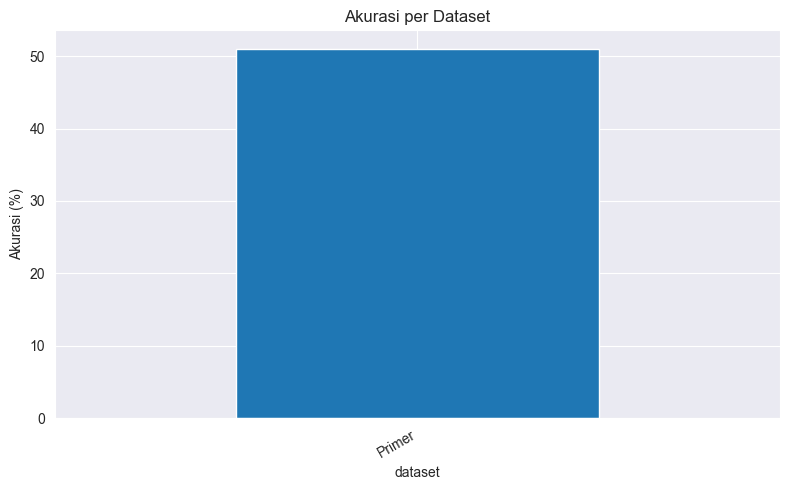

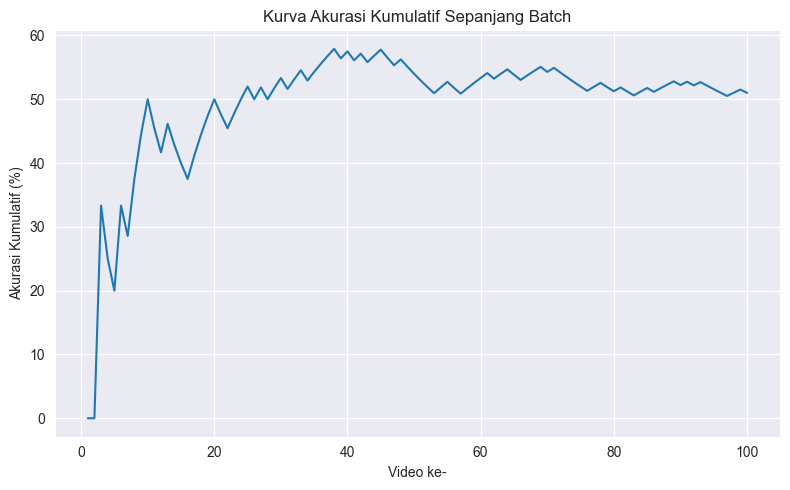

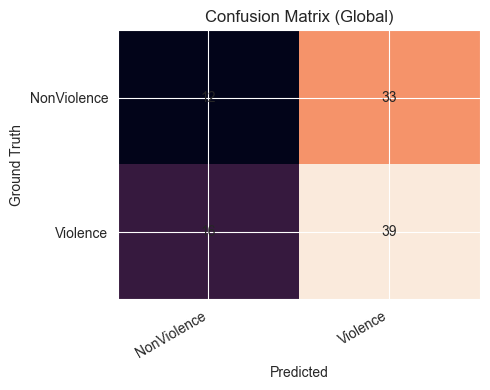

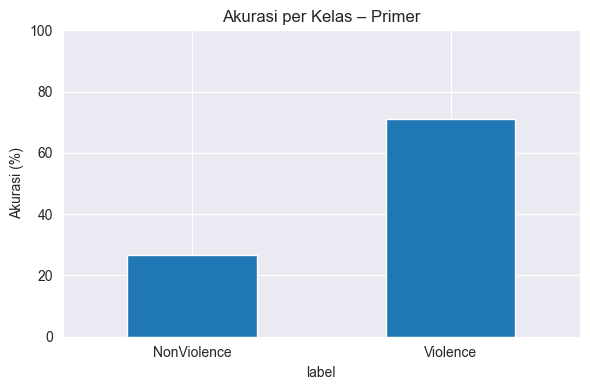

In [24]:
df = results_to_df(results)

# Visualisasi
plot_accuracy_by_dataset(df, out_path='acc_per_dataset.png')
plot_cumulative_accuracy(df, out_path='kurva_kumulatif.png')
plot_confusion_matrix_overall(df, out_path='confusion_matrix.png')
plot_per_class_accuracy_by_dataset(df, out_dir='plots_per_dataset')

# Ekspor ringkasan
export_summaries(df, out_dir='summaries')


In [27]:
samples = get_random_samples_from_test_dirs(DIR_TESTS, num_samples_per_dataset=100)
results = run_batch_gradcam_tests(samples, test_videos_directory)
summarize_batch_results(results)


[Sampling] Primer: Violence=50, NonViolence=50 (total=100, target=100)

🎞️ Memproses: violence_061 (Primer/Violence)
--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_061.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:45<00:00,  1.53frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_061.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 23 frame (41.82%)
🟢 NonViolence: 32 frame (58.18%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.6452 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_061.mp4

🎞️ Memproses: violence_041 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_041.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:35<00:00,  2.00frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_041.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 55 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4937 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_041.mp4

🎞️ Memproses: violence_045 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_045.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.11frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_045.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 44 frame (80.00%)
🟢 NonViolence: 11 frame (20.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4678 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_045.mp4

🎞️ Memproses: violence_101 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_101.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:41<00:00,  1.73frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_101.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 146 frame (91.25%)
🟢 NonViolence: 14 frame (8.75%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5730 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_101.mp4

🎞️ Memproses: violence_017_Blurred (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_017_Blurred.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.16frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_017_Blurred.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 44 frame (80.00%)
🟢 NonViolence: 11 frame (20.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4603 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_017_Blurred.mp4

🎞️ Memproses: violence_096 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_096.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:45<00:00,  1.66frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_096.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 70 frame (43.75%)
🟢 NonViolence: 90 frame (56.25%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5908 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_096.mp4

🎞️ Memproses: violence_067 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_067.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.14frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_067.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 50 frame (90.91%)
🟢 NonViolence: 5 frame (9.09%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4643 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_067.mp4

🎞️ Memproses: violence_039 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_039.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.08frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_039.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 21 frame (38.18%)
🟢 NonViolence: 34 frame (61.82%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4756 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_039.mp4

🎞️ Memproses: violence_120 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_120.mp4 ---
Total Frame: 174
Durasi Video: 6.96 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 174/174 [01:43<00:00,  1.68frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_120.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 159
🔴 Violence: 111 frame (69.81%)
🟢 NonViolence: 48 frame (30.19%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5860 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_120.mp4

🎞️ Memproses: violence_070_blur (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_070_blur.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:43<00:00,  1.68frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_070_blur.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 84 frame (52.50%)
🟢 NonViolence: 76 frame (47.50%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5842 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_070_blur.mp4

🎞️ Memproses: violence_010 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_010.mp4 ---
Total Frame: 30
Durasi Video: 3.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 30/30 [00:08<00:00,  3.45frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_010.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 15
🔴 Violence: 15 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.2870 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_010.mp4

🎞️ Memproses: violence_094 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_094.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:39<00:00,  1.77frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_094.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 99 frame (61.88%)
🟢 NonViolence: 61 frame (38.12%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5600 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_094.mp4

🎞️ Memproses: violence_085 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_085.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:44<00:00,  1.67frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_085.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 105 frame (65.62%)
🟢 NonViolence: 55 frame (34.38%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5892 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_085.mp4

🎞️ Memproses: violence_072 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_072.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:39<00:00,  1.76frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_072.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 86 frame (53.75%)
🟢 NonViolence: 74 frame (46.25%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5630 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_072.mp4

🎞️ Memproses: violence_099 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_099.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:39<00:00,  1.77frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_099.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 113 frame (70.62%)
🟢 NonViolence: 47 frame (29.38%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5599 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_099.mp4

🎞️ Memproses: violence_071_blur (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_071_blur.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:44<00:00,  1.68frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_071_blur.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 71 frame (44.38%)
🟢 NonViolence: 89 frame (55.62%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5859 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_071_blur.mp4

🎞️ Memproses: violence_025 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_025.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:37<00:00,  1.79frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_025.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 148 frame (92.50%)
🟢 NonViolence: 12 frame (7.50%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5562 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_025.mp4

🎞️ Memproses: violence_038 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_038.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:22<00:00,  2.24frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_038.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 0 frame (0.00%)
🟢 NonViolence: 35 frame (100.00%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4407 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_038.mp4

🎞️ Memproses: violence_064 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_064.mp4 ---
Total Frame: 150
Durasi Video: 6.00 detik
Resolusi Frame: 1280x720
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 150/150 [01:41<00:00,  1.47frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_064.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 135
🔴 Violence: 104 frame (77.04%)
🟢 NonViolence: 31 frame (22.96%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.6742 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_064.mp4

🎞️ Memproses: violence_118 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_118.mp4 ---
Total Frame: 174
Durasi Video: 6.96 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 174/174 [01:45<00:00,  1.64frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_118.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 159
🔴 Violence: 95 frame (59.75%)
🟢 NonViolence: 64 frame (40.25%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5961 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_118.mp4

🎞️ Memproses: violence_086 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_086.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:39<00:00,  1.76frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_086.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 71 frame (44.38%)
🟢 NonViolence: 89 frame (55.62%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5609 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_086.mp4

🎞️ Memproses: violence_112 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_112.mp4 ---
Total Frame: 106
Durasi Video: 4.24 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 106/106 [00:57<00:00,  1.86frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_112.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 91
🔴 Violence: 66 frame (72.53%)
🟢 NonViolence: 25 frame (27.47%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5312 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_112.mp4

🎞️ Memproses: violence_119 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_119.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:43<00:00,  1.69frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_119.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 114 frame (71.25%)
🟢 NonViolence: 46 frame (28.75%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5816 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_119.mp4

🎞️ Memproses: violence_014 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_014.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.15frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_014.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 34 frame (61.82%)
🟢 NonViolence: 21 frame (38.18%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4609 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_014.mp4

🎞️ Memproses: violence_001 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_001.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.16frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_001.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 46 frame (83.64%)
🟢 NonViolence: 9 frame (16.36%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4600 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_001.mp4

🎞️ Memproses: violence_102 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_102.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:44<00:00,  1.67frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_102.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 130 frame (81.25%)
🟢 NonViolence: 30 frame (18.75%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5871 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_102.mp4

🎞️ Memproses: violence_019 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_019.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:34<00:00,  1.86frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_019.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 137 frame (85.62%)
🟢 NonViolence: 23 frame (14.38%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5353 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_019.mp4

🎞️ Memproses: violence_065 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_065.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:36<00:00,  1.82frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_065.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 117 frame (73.12%)
🟢 NonViolence: 43 frame (26.88%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5463 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_065.mp4

🎞️ Memproses: violence_110 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_110.mp4 ---
Total Frame: 87
Durasi Video: 3.48 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 87/87 [00:44<00:00,  1.94frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_110.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 72
🔴 Violence: 34 frame (47.22%)
🟢 NonViolence: 38 frame (52.78%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5091 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_110.mp4

🎞️ Memproses: violence_012 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_012.mp4 ---
Total Frame: 69
Durasi Video: 7.10 detik
Resolusi Frame: 1280x720
FPS Video: 9.7
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:32<00:00,  2.14frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_012.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 50 frame (92.59%)
🟢 NonViolence: 4 frame (7.41%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4651 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_012.mp4

🎞️ Memproses: violence_109 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_109.mp4 ---
Total Frame: 110
Durasi Video: 4.40 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 110/110 [00:57<00:00,  1.90frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_109.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 95
🔴 Violence: 61 frame (64.21%)
🟢 NonViolence: 34 frame (35.79%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5210 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_109.mp4

🎞️ Memproses: violence_063 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_063.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.17frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_063.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 33 frame (60.00%)
🟢 NonViolence: 22 frame (40.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4571 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_063.mp4

🎞️ Memproses: violence_021 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_021.mp4 ---
Total Frame: 69
Durasi Video: 6.90 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:32<00:00,  2.13frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_021.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 46 frame (85.19%)
🟢 NonViolence: 8 frame (14.81%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4654 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_021.mp4

🎞️ Memproses: violence_076 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_076.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:37<00:00,  1.79frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_076.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 65 frame (40.62%)
🟢 NonViolence: 95 frame (59.38%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5519 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_076.mp4

🎞️ Memproses: violence_051 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_051.mp4 ---
Total Frame: 60
Durasi Video: 6.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 60/60 [00:27<00:00,  2.17frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_051.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 45
🔴 Violence: 45 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4547 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_051.mp4

🎞️ Memproses: violence_081 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_081.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:39<00:00,  1.75frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_081.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 109 frame (68.12%)
🟢 NonViolence: 51 frame (31.88%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5641 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_081.mp4

🎞️ Memproses: violence_114 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_114.mp4 ---
Total Frame: 174
Durasi Video: 6.96 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 174/174 [01:41<00:00,  1.71frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_114.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 159
🔴 Violence: 111 frame (69.81%)
🟢 NonViolence: 48 frame (30.19%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5749 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_114.mp4

🎞️ Memproses: violence_016 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_016.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.15frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_016.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 34 frame (61.82%)
🟢 NonViolence: 21 frame (38.18%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4618 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_016.mp4

🎞️ Memproses: violence_095 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_095.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:38<00:00,  1.77frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_095.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 50 frame (31.25%)
🟢 NonViolence: 110 frame (68.75%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5576 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_095.mp4

🎞️ Memproses: violence_005 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_005.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.12frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_005.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 35 frame (63.64%)
🟢 NonViolence: 20 frame (36.36%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4684 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_005.mp4

🎞️ Memproses: violence_013 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_013.mp4 ---
Total Frame: 69
Durasi Video: 7.10 detik
Resolusi Frame: 1280x720
FPS Video: 9.7
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:32<00:00,  2.15frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_013.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 29 frame (53.70%)
🟢 NonViolence: 25 frame (46.30%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4615 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_013.mp4

🎞️ Memproses: violence_070 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_070.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:45<00:00,  1.66frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_070.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 82 frame (51.25%)
🟢 NonViolence: 78 frame (48.75%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5928 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_070.mp4

🎞️ Memproses: violence_023 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_023.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.12frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_023.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 50 frame (90.91%)
🟢 NonViolence: 5 frame (9.09%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4676 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_023.mp4

🎞️ Memproses: violence_113 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_113.mp4 ---
Total Frame: 124
Durasi Video: 4.96 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 124/124 [01:07<00:00,  1.83frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_113.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 109
🔴 Violence: 52 frame (47.71%)
🟢 NonViolence: 57 frame (52.29%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5408 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_113.mp4

🎞️ Memproses: violence_035 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_035.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.12frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_035.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 48 frame (87.27%)
🟢 NonViolence: 7 frame (12.73%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4662 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_035.mp4

🎞️ Memproses: violence_111 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_111.mp4 ---
Total Frame: 174
Durasi Video: 6.96 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 174/174 [01:44<00:00,  1.67frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_111.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 159
🔴 Violence: 113 frame (71.07%)
🟢 NonViolence: 46 frame (28.93%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5896 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_111.mp4

🎞️ Memproses: violence_002 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_002.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.13frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_002.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 14 frame (25.45%)
🟢 NonViolence: 41 frame (74.55%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4666 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_002.mp4

🎞️ Memproses: violence_036 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_036.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.12frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_036.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 55 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4668 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_036.mp4

🎞️ Memproses: violence_075 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_075.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:41<00:00,  1.73frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_075.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 88 frame (55.00%)
🟢 NonViolence: 72 frame (45.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5722 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_075.mp4

🎞️ Memproses: violence_104 (Primer/Violence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\Violence\violence_104.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:42<00:00,  1.71frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: violence_104.mp4
🔖 Ground Truth (berdasarkan folder): Violence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 126 frame (78.75%)
🟢 NonViolence: 34 frame (21.25%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5777 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_Violence_violence_104.mp4

🎞️ Memproses: non_violence_100 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_100.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.09frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_100.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 45 frame (81.82%)
🟢 NonViolence: 10 frame (18.18%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4718 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_100.mp4

🎞️ Memproses: non_violence_041 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_041.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:34<00:00,  2.06frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_041.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 51 frame (92.73%)
🟢 NonViolence: 4 frame (7.27%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4800 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_041.mp4

🎞️ Memproses: non_violence_031 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_031.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.07frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_031.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 32 frame (58.18%)
🟢 NonViolence: 23 frame (41.82%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4767 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_031.mp4

🎞️ Memproses: non_violence_037 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_037.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.07frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_037.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 42 frame (76.36%)
🟢 NonViolence: 13 frame (23.64%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4764 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_037.mp4

🎞️ Memproses: non_violence_051 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_051.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:46<00:00,  1.65frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_051.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 108 frame (67.50%)
🟢 NonViolence: 52 frame (32.50%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5970 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_051.mp4

🎞️ Memproses: non_violence_080 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_080.mp4 ---
Total Frame: 0
Durasi Video: 0.00 detik
Resolusi Frame: 0x0
FPS Video: 0.0
Jumlah Frame Ekstraksi: 16


Processing Video: 0frame [00:00, ?frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_080.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 0
🔴 Violence: 0 frame (0.00%)
🟢 NonViolence: 0 frame (100.00%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: nan detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_080.mp4

🎞️ Memproses: non_violence_072 (Primer/NonViolence)



E:\Anaconda\envs\py310\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda\envs\py310\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_072.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:47<00:00,  1.63frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_072.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 109 frame (68.12%)
🟢 NonViolence: 51 frame (31.88%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.6022 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_072.mp4

🎞️ Memproses: non_violence_098 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_098.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.06frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_098.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 48 frame (87.27%)
🟢 NonViolence: 7 frame (12.73%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4797 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_098.mp4

🎞️ Memproses: non_violence_085 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_085.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:34<00:00,  2.02frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_085.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 37 frame (67.27%)
🟢 NonViolence: 18 frame (32.73%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4887 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_085.mp4

🎞️ Memproses: non_violence_044 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_044.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:20<00:00,  2.44frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_044.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 15 frame (42.86%)
🟢 NonViolence: 20 frame (57.14%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4049 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_044.mp4

🎞️ Memproses: non_violence_006 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_006.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:32<00:00,  2.14frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_006.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 14 frame (25.45%)
🟢 NonViolence: 41 frame (74.55%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4643 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_006.mp4

🎞️ Memproses: non_violence_069 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_069.mp4 ---
Total Frame: 174
Durasi Video: 6.96 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 174/174 [01:45<00:00,  1.65frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_069.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 159
🔴 Violence: 112 frame (70.44%)
🟢 NonViolence: 47 frame (29.56%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5957 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_069.mp4

🎞️ Memproses: non_violence_033 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_033.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.11frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_033.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 46 frame (83.64%)
🟢 NonViolence: 9 frame (16.36%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4679 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_033.mp4

🎞️ Memproses: non_violence_061 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_061.mp4 ---
Total Frame: 174
Durasi Video: 6.96 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 174/174 [01:45<00:00,  1.66frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_061.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 159
🔴 Violence: 140 frame (88.05%)
🟢 NonViolence: 19 frame (11.95%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5938 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_061.mp4

🎞️ Memproses: non_violence_001 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_001.mp4 ---
Total Frame: 69
Durasi Video: 7.10 detik
Resolusi Frame: 1280x720
FPS Video: 9.7
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:32<00:00,  2.15frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_001.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 8 frame (14.81%)
🟢 NonViolence: 46 frame (85.19%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4609 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_001.mp4

🎞️ Memproses: non_violence_054 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_054.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:46<00:00,  1.65frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_054.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 134 frame (83.75%)
🟢 NonViolence: 26 frame (16.25%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5976 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_054.mp4

🎞️ Memproses: non_violence_007 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_007.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.09frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_007.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 50 frame (90.91%)
🟢 NonViolence: 5 frame (9.09%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4758 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_007.mp4

🎞️ Memproses: non_violence_056 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_056.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:44<00:00,  1.68frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_056.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 61 frame (38.12%)
🟢 NonViolence: 99 frame (61.88%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5861 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_056.mp4

🎞️ Memproses: non_violence_095 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_095.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.10frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_095.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 55 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4706 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_095.mp4

🎞️ Memproses: non_violence_087 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_087.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:34<00:00,  2.02frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_087.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 43 frame (78.18%)
🟢 NonViolence: 12 frame (21.82%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4895 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_087.mp4

🎞️ Memproses: non_violence_008 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_008.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:34<00:00,  2.04frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_008.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 44 frame (80.00%)
🟢 NonViolence: 11 frame (20.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4876 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_008.mp4

🎞️ Memproses: non_violence_093 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_093.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:35<00:00,  1.98frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_093.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 24 frame (43.64%)
🟢 NonViolence: 31 frame (56.36%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4979 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_093.mp4

🎞️ Memproses: non_violence_011 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_011.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:22<00:00,  2.26frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_011.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 35 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4381 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_011.mp4

🎞️ Memproses: non_violence_091 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_091.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:34<00:00,  2.01frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_091.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 41 frame (74.55%)
🟢 NonViolence: 14 frame (25.45%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4907 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_091.mp4

🎞️ Memproses: non_violence_045 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_045.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:45<00:00,  1.66frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_045.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 62 frame (38.75%)
🟢 NonViolence: 98 frame (61.25%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5930 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_045.mp4

🎞️ Memproses: non_violence_078 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_078.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:34<00:00,  2.03frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_078.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 51 frame (92.73%)
🟢 NonViolence: 4 frame (7.27%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4871 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_078.mp4

🎞️ Memproses: non_violence_079 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_079.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.10frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_079.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 54 frame (98.18%)
🟢 NonViolence: 1 frame (1.82%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4709 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_079.mp4

🎞️ Memproses: non_violence_058 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_058.mp4 ---
Total Frame: 174
Durasi Video: 6.96 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 174/174 [01:45<00:00,  1.65frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_058.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 159
🔴 Violence: 98 frame (61.64%)
🟢 NonViolence: 61 frame (38.36%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5945 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_058.mp4

🎞️ Memproses: non_violence_010 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_010.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.09frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_010.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 45 frame (81.82%)
🟢 NonViolence: 10 frame (18.18%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4751 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_010.mp4

🎞️ Memproses: non_violence_063 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_063.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:47<00:00,  1.62frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_063.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 109 frame (68.12%)
🟢 NonViolence: 51 frame (31.88%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.6060 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_063.mp4

🎞️ Memproses: non_violence_059 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_059.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:46<00:00,  1.64frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_059.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 88 frame (55.00%)
🟢 NonViolence: 72 frame (45.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5982 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_059.mp4

🎞️ Memproses: non_violence_016 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_016.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:35<00:00,  1.99frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_016.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 36 frame (65.45%)
🟢 NonViolence: 19 frame (34.55%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4958 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_016.mp4

🎞️ Memproses: non_violence_060 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_060.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:45<00:00,  1.66frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_060.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 146 frame (91.25%)
🟢 NonViolence: 14 frame (8.75%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5930 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_060.mp4

🎞️ Memproses: non_violence_092 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_092.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.10frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_092.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 50 frame (90.91%)
🟢 NonViolence: 5 frame (9.09%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4704 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_092.mp4

🎞️ Memproses: non_violence_039 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_039.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:34<00:00,  2.01frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_039.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 32 frame (58.18%)
🟢 NonViolence: 23 frame (41.82%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4903 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_039.mp4

🎞️ Memproses: non_violence_043 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_043.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:20<00:00,  2.39frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_043.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 8 frame (22.86%)
🟢 NonViolence: 27 frame (77.14%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4120 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_043.mp4

🎞️ Memproses: non_violence_025 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_025.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.06frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_025.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 22 frame (40.00%)
🟢 NonViolence: 33 frame (60.00%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4782 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_025.mp4

🎞️ Memproses: non_violence_014 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_014.mp4 ---
Total Frame: 69
Durasi Video: 7.10 detik
Resolusi Frame: 1920x1080
FPS Video: 9.7
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 69/69 [00:33<00:00,  2.08frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_014.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 54
🔴 Violence: 21 frame (38.89%)
🟢 NonViolence: 33 frame (61.11%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4740 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_014.mp4

🎞️ Memproses: non_violence_009 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_009.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1280x720
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.06frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_009.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 52 frame (94.55%)
🟢 NonViolence: 3 frame (5.45%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4811 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_009.mp4

🎞️ Memproses: non_violence_066 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_066.mp4 ---
Total Frame: 174
Durasi Video: 6.96 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 174/174 [01:46<00:00,  1.64frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_066.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 159
🔴 Violence: 63 frame (39.62%)
🟢 NonViolence: 96 frame (60.38%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.6006 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_066.mp4

🎞️ Memproses: non_violence_021 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_021.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:22<00:00,  2.23frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_021.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 29 frame (82.86%)
🟢 NonViolence: 6 frame (17.14%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4421 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_021.mp4

🎞️ Memproses: non_violence_070 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_070.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:44<00:00,  1.67frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_070.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 117 frame (73.12%)
🟢 NonViolence: 43 frame (26.88%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5894 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_070.mp4

🎞️ Memproses: non_violence_022 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_022.mp4 ---
Total Frame: 50
Durasi Video: 5.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 50/50 [00:22<00:00,  2.20frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_022.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 35
🔴 Violence: 3 frame (8.57%)
🟢 NonViolence: 32 frame (91.43%)
🏷️ Prediksi Akhir: NonViolence
✅ Kesesuaian: ✔️ Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4477 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_022.mp4

🎞️ Memproses: non_violence_034 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_034.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:35<00:00,  1.99frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_034.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 48 frame (87.27%)
🟢 NonViolence: 7 frame (12.73%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4961 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_034.mp4

🎞️ Memproses: non_violence_099 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_099.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.08frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_099.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 48 frame (87.27%)
🟢 NonViolence: 7 frame (12.73%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4745 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_099.mp4

🎞️ Memproses: non_violence_055 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_055.mp4 ---
Total Frame: 174
Durasi Video: 6.96 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 174/174 [01:45<00:00,  1.65frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_055.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 159
🔴 Violence: 133 frame (83.65%)
🟢 NonViolence: 26 frame (16.35%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.5973 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_055.mp4

🎞️ Memproses: non_violence_026 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_026.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:33<00:00,  2.09frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_026.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 36 frame (65.45%)
🟢 NonViolence: 19 frame (34.55%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4732 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_026.mp4

🎞️ Memproses: non_violence_075 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_075.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:34<00:00,  2.04frame/s] 


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_075.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 38 frame (69.09%)
🟢 NonViolence: 17 frame (30.91%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4841 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_075.mp4

🎞️ Memproses: non_violence_052 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_052.mp4 ---
Total Frame: 175
Durasi Video: 7.00 detik
Resolusi Frame: 2560x1440
FPS Video: 25.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 175/175 [01:47<00:00,  1.62frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_052.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 160
🔴 Violence: 106 frame (66.25%)
🟢 NonViolence: 54 frame (33.75%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.6064 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_052.mp4

🎞️ Memproses: non_violence_088 (Primer/NonViolence)


--- Info Video: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001\Primer_Clipped\NonViolence\non_violence_088.mp4 ---
Total Frame: 70
Durasi Video: 7.00 detik
Resolusi Frame: 1920x1080
FPS Video: 10.0
Jumlah Frame Ekstraksi: 16


Processing Video: 100%|██████████| 70/70 [00:34<00:00,  2.01frame/s]


📊 Ringkasan Prediksi Video:
📁 Nama Video: non_violence_088.mp4
🔖 Ground Truth (berdasarkan folder): NonViolence
🧮 Total Frame yang Diprediksi: 55
🔴 Violence: 55 frame (100.00%)
🟢 NonViolence: 0 frame (0.00%)
🏷️ Prediksi Akhir: Violence
✅ Kesesuaian: ❌ Tidak Sesuai

⏱️ Rata-rata waktu inferensi per frame: 0.4920 detik
💾 Output video disimpan di: E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\PreTrained\Primer_Clipped-20250819T025200Z-1-001/processed_videos\Hasil_Gradcam_Primer_NonViolence_non_violence_088.mp4

📊 Ringkasan Evaluasi Batch:
- Primer: 51/100 benar (51.00% akurasi)

🎯 Total Akurasi Global: 51/100 (51.00%)


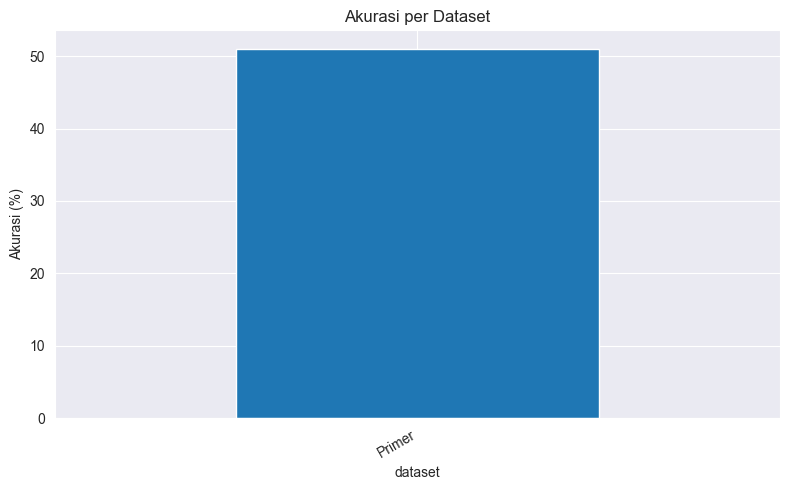

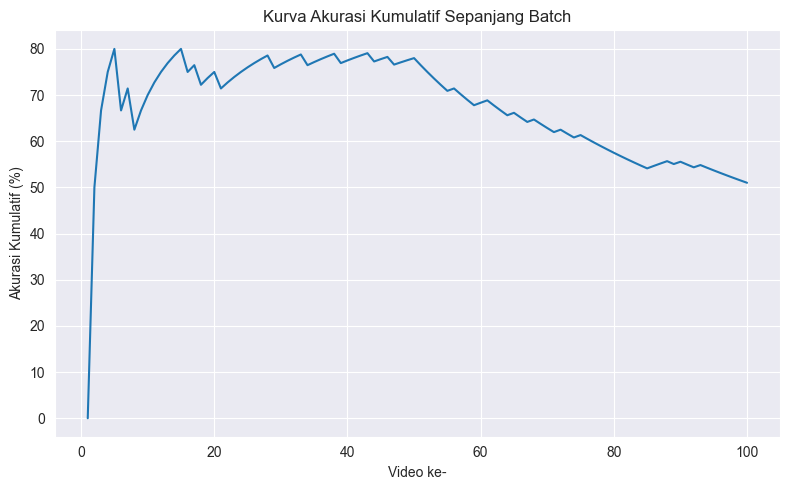

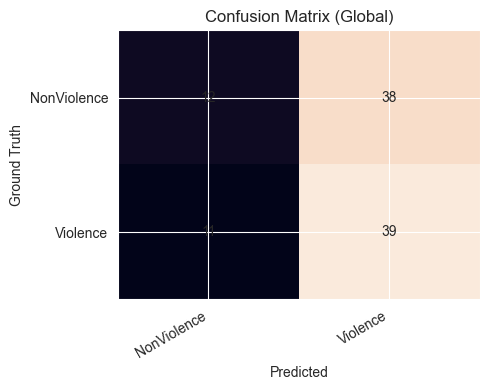

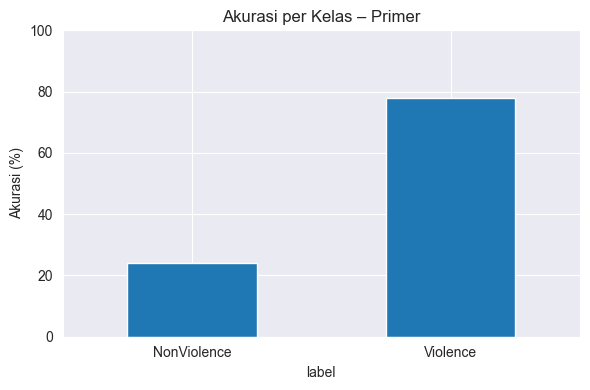

In [29]:
df = results_to_df(results)

# Visualisasi
plot_accuracy_by_dataset(df, out_path='acc_per_dataset.png')
plot_cumulative_accuracy(df, out_path='kurva_kumulatif.png')
plot_confusion_matrix_overall(df, out_path='confusion_matrix.png')
plot_per_class_accuracy_by_dataset(df, out_dir='plots_per_dataset')

# Ekspor ringkasan
export_summaries(df, out_dir='summaries')


In [ ]:
# # Path video input dan output
# test_videos_directory = r'E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\Pengujian_2\Test_model_video\Gradcam\Polos'
# os.makedirs(test_videos_directory, exist_ok=True)

In [ ]:
# output_video_file_path = f'{test_videos_directory}/Hasil Test Pretrain_gradcam_Hockey_1.mp4'
# input_video_file_path = r'E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\Pengujian_2\Testing\HockeyFight\Violence\fi1_xvid.avi'

# # Lakukan prediksi pada video dengan Grad-CAM
# predict_frames_with_gradcam(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# # Tampilkan beberapa frame hasil prediksi dengan Grad-CAM
# show_pred_frames_with_gradcam(output_video_file_path)

In [ ]:
# output_video_file_path = f'{test_videos_directory}/Hasil Test Pretrain_gradcam_Hockey_1.mp4'
# input_video_file_path = r'E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\Pengujian_2\Testing\HockeyFight\Violence\fi1_xvid.avi'
#
# # Lakukan prediksi pada video dengan Grad-CAM
# predict_frames_with_gradcam(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
#
# # Tampilkan beberapa frame hasil prediksi dengan Grad-CAM
# show_pred_frames_with_gradcam(output_video_file_path)

In [ ]:
# # Load model
# model_filename = r'E:\KULIAH\TA_SI_GUE\Tugas_akhir\@new_process\new_dataset\Pengujian_2\Output_Pelatihan_3\Eff2Bilstm_checkpoint.pth'
# model = EfficientFormerV2WithBiLSTM('efficientformerv2_s0', num_classes=NUM_CLASSES, use_attention=True)

# # Load checkpoint dengan deteksi error
# checkpoint = torch.load(model_filename, map_location=DEVICE)
# if 'model_state_dict' in checkpoint:
#     model.load_state_dict(checkpoint['model_state_dict'], strict=False)  # Jika model berbeda
# else:
#     model.load_state_dict(checkpoint, strict=False)

# # Pindahkan ke device
# model.to(DEVICE)
# model.eval()
# print("✅ Model berhasil dimuat!")


In [ ]:
# samples = get_random_samples_from_test_dirs(DIR_TESTS, num_samples_per_dataset=5)
# results = run_batch_gradcam_tests(samples, test_videos_directory)
# summarize_batch_results(results)


In [ ]:
# # Path video input dan output
# output_video_file_path = f'{test_videos_directory}/Hasil Test Polos_gradcam.mp4'
# input_video_file_path = r'E:\KULIAH\TA_SI_GUE\Tugas_akhir\Automatic\Violence\80.mp4'

# # Lakukan prediksi pada video dengan Grad-CAM
# predict_frames_with_gradcam(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# # Tampilkan beberapa frame hasil prediksi dengan Grad-CAM
# show_pred_frames_with_gradcam(output_video_file_path)



In [ ]:
# # Path video input dan output
# output_video_file_path = f'{test_videos_directory}/Output-Test-Video-GradCAM4_coba.mp4'
# input_video_file_path = r'E:\KULIAH\TA_SI_GUE\Tugas_akhir\video_for_test\fight1.mp4'

# # Lakukan prediksi pada video dengan Grad-CAM
# predict_frames_with_gradcam(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# # Tampilkan beberapa frame hasil prediksi dengan Grad-CAM
# show_pred_frames_with_gradcam(output_video_file_path)



In [ ]:
# # Path video input dan output
# output_video_file_path = f'{test_videos_directory}/Output-Test-Video-GradCAM6.mp4'
# input_video_file_path = r'E:\KULIAH\Riset TA\Violence-Alert-System\ViolenceDetection\Testingvideos\Real Life Violence Dataset\Kekerasan\V_9.mp4'

# # Lakukan prediksi pada video dengan Grad-CAM
# predict_frames_with_gradcam(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# # Tampilkan beberapa frame hasil prediksi dengan Grad-CAM
# show_pred_frames_with_gradcam(output_video_file_path)



In [ ]:
# from ptflops import get_model_complexity_info

# # Pastikan input size sesuai dengan bentuk input model
# flops, params = get_model_complexity_info(
#     model, (SEQUENCE_LENGTH, 3, IMAGE_HEIGHT, IMAGE_WIDTH), as_strings=True, print_per_layer_stat=False
# )

# print(f"Model GFLOPs: {flops}")
# print(f"Model Parameters: {params}")

